### Part 2a

Import libraries and set viridis color palette

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os
# Set color palette to viridis
sns.set_palette("viridis")

### Import data
Import combined flight data if exists, else import raw data and combine them,
and then export the combined data into new csv for future usage. I have filtered out cancelled flights as I import the data to reduce memory usage.

In [2]:
# specify columns to extract, and dtype of each columns
dtype_dict = {
    "Year": "Int16",
    "Month": "Int8",
    "DayofMonth": "Int8",
    "DayOfWeek": "Int8", 
    "DepTime": "Int16",
    "CRSDepTime": "Int16",
    "ArrTime": "Int16",
    "CRSArrTime": "Int16",
    "UniqueCarrier": "category",   # Strings use a lot of memory; "category" saves space
    "FlightNum": "Int32",
    "TailNum": "category",
    "ActualElapsedTime": "Int16",
    "CRSElapsedTime": "Int16",
    "AirTime": "Int16",
    "ArrDelay": "Int16",
    "DepDelay": "Int16",
    "Origin": "category",
    "Dest": "category",
    "Distance": "Int16",
    "TaxiIn": "Int16",
    "TaxiOut": "Int16",
    "Cancelled": "bool",
    "CancellationCode": "category",
    "Diverted": "bool",
    "CarrierDelay": "Int16",
    "WeatherDelay": "Int16",
    "NASDelay": "Int16",
    "SecurityDelay": "Int16",
    "LateAircraftDelay": "Int16"
}

# check if 'combined_data' csv exists, read in chunks if exists
if os.path.exists("combined_data.csv"):
    chunks = []  
    for chunk in pd.read_csv("combined_data.csv", usecols=dtype_dict.keys(), dtype=dtype_dict, chunksize=500000):  
        chunks.append(chunk)  
    # Combine all chunks  
    flight_df = pd.concat(chunks, ignore_index=True)
    print("\nImported combined_data.csv, rows:", flight_df.shape[0], "Years available: ", flight_df['Year'].unique())
else:
    # empty list to store all years data
    alldata = []
    # read 2003 - 2007 data year by year 
    for i in range(2003, 2008):
        # read one year data in chunks of 500,000 rows
        for chunk in pd.read_csv(f"{i}.csv", usecols=dtype_dict.keys(), dtype=dtype_dict, chunksize=500000):
            alldata.append(chunk)
        # for troubleshooting
        print(i, "chunks added to alldata")
    # combine all chunks into one df
    flight_df = pd.concat(alldata, ignore_index=True)
    print("\nflight_df rows:", flight_df.shape[0], ", Years available:", flight_df['Year'].unique())
    
    # export to one csv
    flight_df.to_csv("combined_data.csv", index=False) 

2003 chunks added to alldata
2004 chunks added to alldata
2005 chunks added to alldata
2006 chunks added to alldata
2007 chunks added to alldata

flight_df rows: 35353543 , Years available: <IntegerArray>
[2003, 2004, 2005, 2006, 2007]
Length: 5, dtype: Int16


In [3]:
print(flight_df.shape)

(35353543, 29)


### Part 2a
For part 2a, we are interested in finding the best days of the week and time to minimize delays of each year. The following shows step by step how could this question be answered.

Since we are only interested in flight delays for flights that actually took of, only flights that are not cancelled will be included.

Filter out cancelled flights

In [4]:
flight_df = flight_df.query("Cancelled == False")

In [5]:
# Convert DayOfWeek to factor 
flight_df['DayOfWeek'] = flight_df['DayOfWeek'].astype('category')

### Part 2a

In [6]:
flight_df[['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].describe()

ArrDelay    DepDelay  CarrierDelay  WeatherDelay    NASDelay  \
count  34635346.0  34707905.0    32083706.0    32083706.0  32083706.0   
mean     7.321709    8.745668      3.176284      0.696051    3.559208   
std     35.063057   31.756753     18.345676      8.749646   15.380369   
min       -1302.0     -1410.0           0.0           0.0       -60.0   
25%          -9.0        -4.0           0.0           0.0         0.0   
50%          -1.0         0.0           0.0           0.0         0.0   
75%          11.0         7.0           0.0           0.0         0.0   
max        2598.0      2601.0        2580.0        1510.0      1392.0   

       SecurityDelay  LateAircraftDelay  
count     32083706.0         32083706.0  
mean         0.02491           4.083609  
std         1.165656          18.692841  
min              0.0                0.0  
25%              0.0                0.0  
50%              0.0                0.0  
75%              0.0                0.0  
max            533.0             1407.0

In [7]:
flight_df[['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].isna().sum()

ArrDelay               72559
DepDelay                   0
CarrierDelay         2624199
WeatherDelay         2624199
NASDelay             2624199
SecurityDelay        2624199
LateAircraftDelay    2624199
dtype: int64

There are six features related to flight delays: ArrDelay, DepDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, and LateAircraftDelay. Some NA and negative values are present in these dalay variables, I will fill the NA to zero, and remove observations with negative delays.

In [8]:
# Replace NA with 0 and filter out negative values
flight_df.fillna({
    'ArrDelay': 0,
    'DepDelay': 0,
    'NASDelay': 0,
    'CarrierDelay': 0,
    'SecurityDelay': 0,
    'WeatherDelay': 0,
    'LateAircraftDelay': 0
}, inplace=True)

# filter out negative values in delay features
flight_df_filtered = flight_df.query('ArrDelay >= 0 & DepDelay >= 0 & NASDelay >= 0 & CarrierDelay >= 0 & SecurityDelay >= 0 & WeatherDelay >= 0 & LateAircraftDelay >= 0')

C:\Users\steve\AppData\Local\Temp\ipykernel_10536\3187191082.py:13: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  flight_df_filtered = flight_df.query('ArrDelay >= 0 & DepDelay >= 0 & NASDelay >= 0 & CarrierDelay >= 0 & SecurityDelay >= 0 & WeatherDelay >= 0 & LateAircraftDelay >= 0')


Create a new variable TotalDelay which sums up all types of delay.

In [9]:
flight_df_filtered['TotalDelay'] = flight_df_filtered[['ArrDelay', 'DepDelay', 'NASDelay', 'CarrierDelay', 'SecurityDelay', 'LateAircraftDelay', 'WeatherDelay']].sum(axis=1)

C:\Users\steve\AppData\Local\Temp\ipykernel_10536\3894450790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df_filtered['TotalDelay'] = flight_df_filtered[['ArrDelay', 'DepDelay', 'NASDelay', 'CarrierDelay', 'SecurityDelay', 'LateAircraftDelay', 'WeatherDelay']].sum(axis=1)


In [10]:
flight_df_filtered['TotalDelay'].describe()

count    12402341.0
mean      90.158483
std      137.564527
min             0.0
25%            12.0
50%            42.0
75%           113.0
max          7797.0
Name: TotalDelay, dtype: Float64

### Delay Summary

I will first group data by `Year`, `DayOfWeek`, and `CRSDepTime`, and aggregate total delay to its mean value. Missing values will be excluded if still present.

In [11]:
delay_summary = flight_df_filtered.groupby(['Year', 'DayOfWeek', 'CRSDepTime'])['TotalDelay'].mean().reset_index(name='avg_TotalDelay')

print(delay_summary)

C:\Users\steve\AppData\Local\Temp\ipykernel_10536\2075229388.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_summary = flight_df_filtered.groupby(['Year', 'DayOfWeek', 'CRSDepTime'])['TotalDelay'].mean().reset_index(name='avg_TotalDelay')


       Year DayOfWeek  CRSDepTime  avg_TotalDelay
0      2003         1           0            <NA>
1      2003         1           1            <NA>
2      2003         1           3            <NA>
3      2003         1           4             8.0
4      2003         1           5            24.5
...     ...       ...         ...             ...
44235  2007         7        2356            74.5
44236  2007         7        2357       85.060606
44237  2007         7        2358      131.796875
44238  2007         7        2359       88.261101
44239  2007         7        2400            <NA>

[44240 rows x 4 columns]


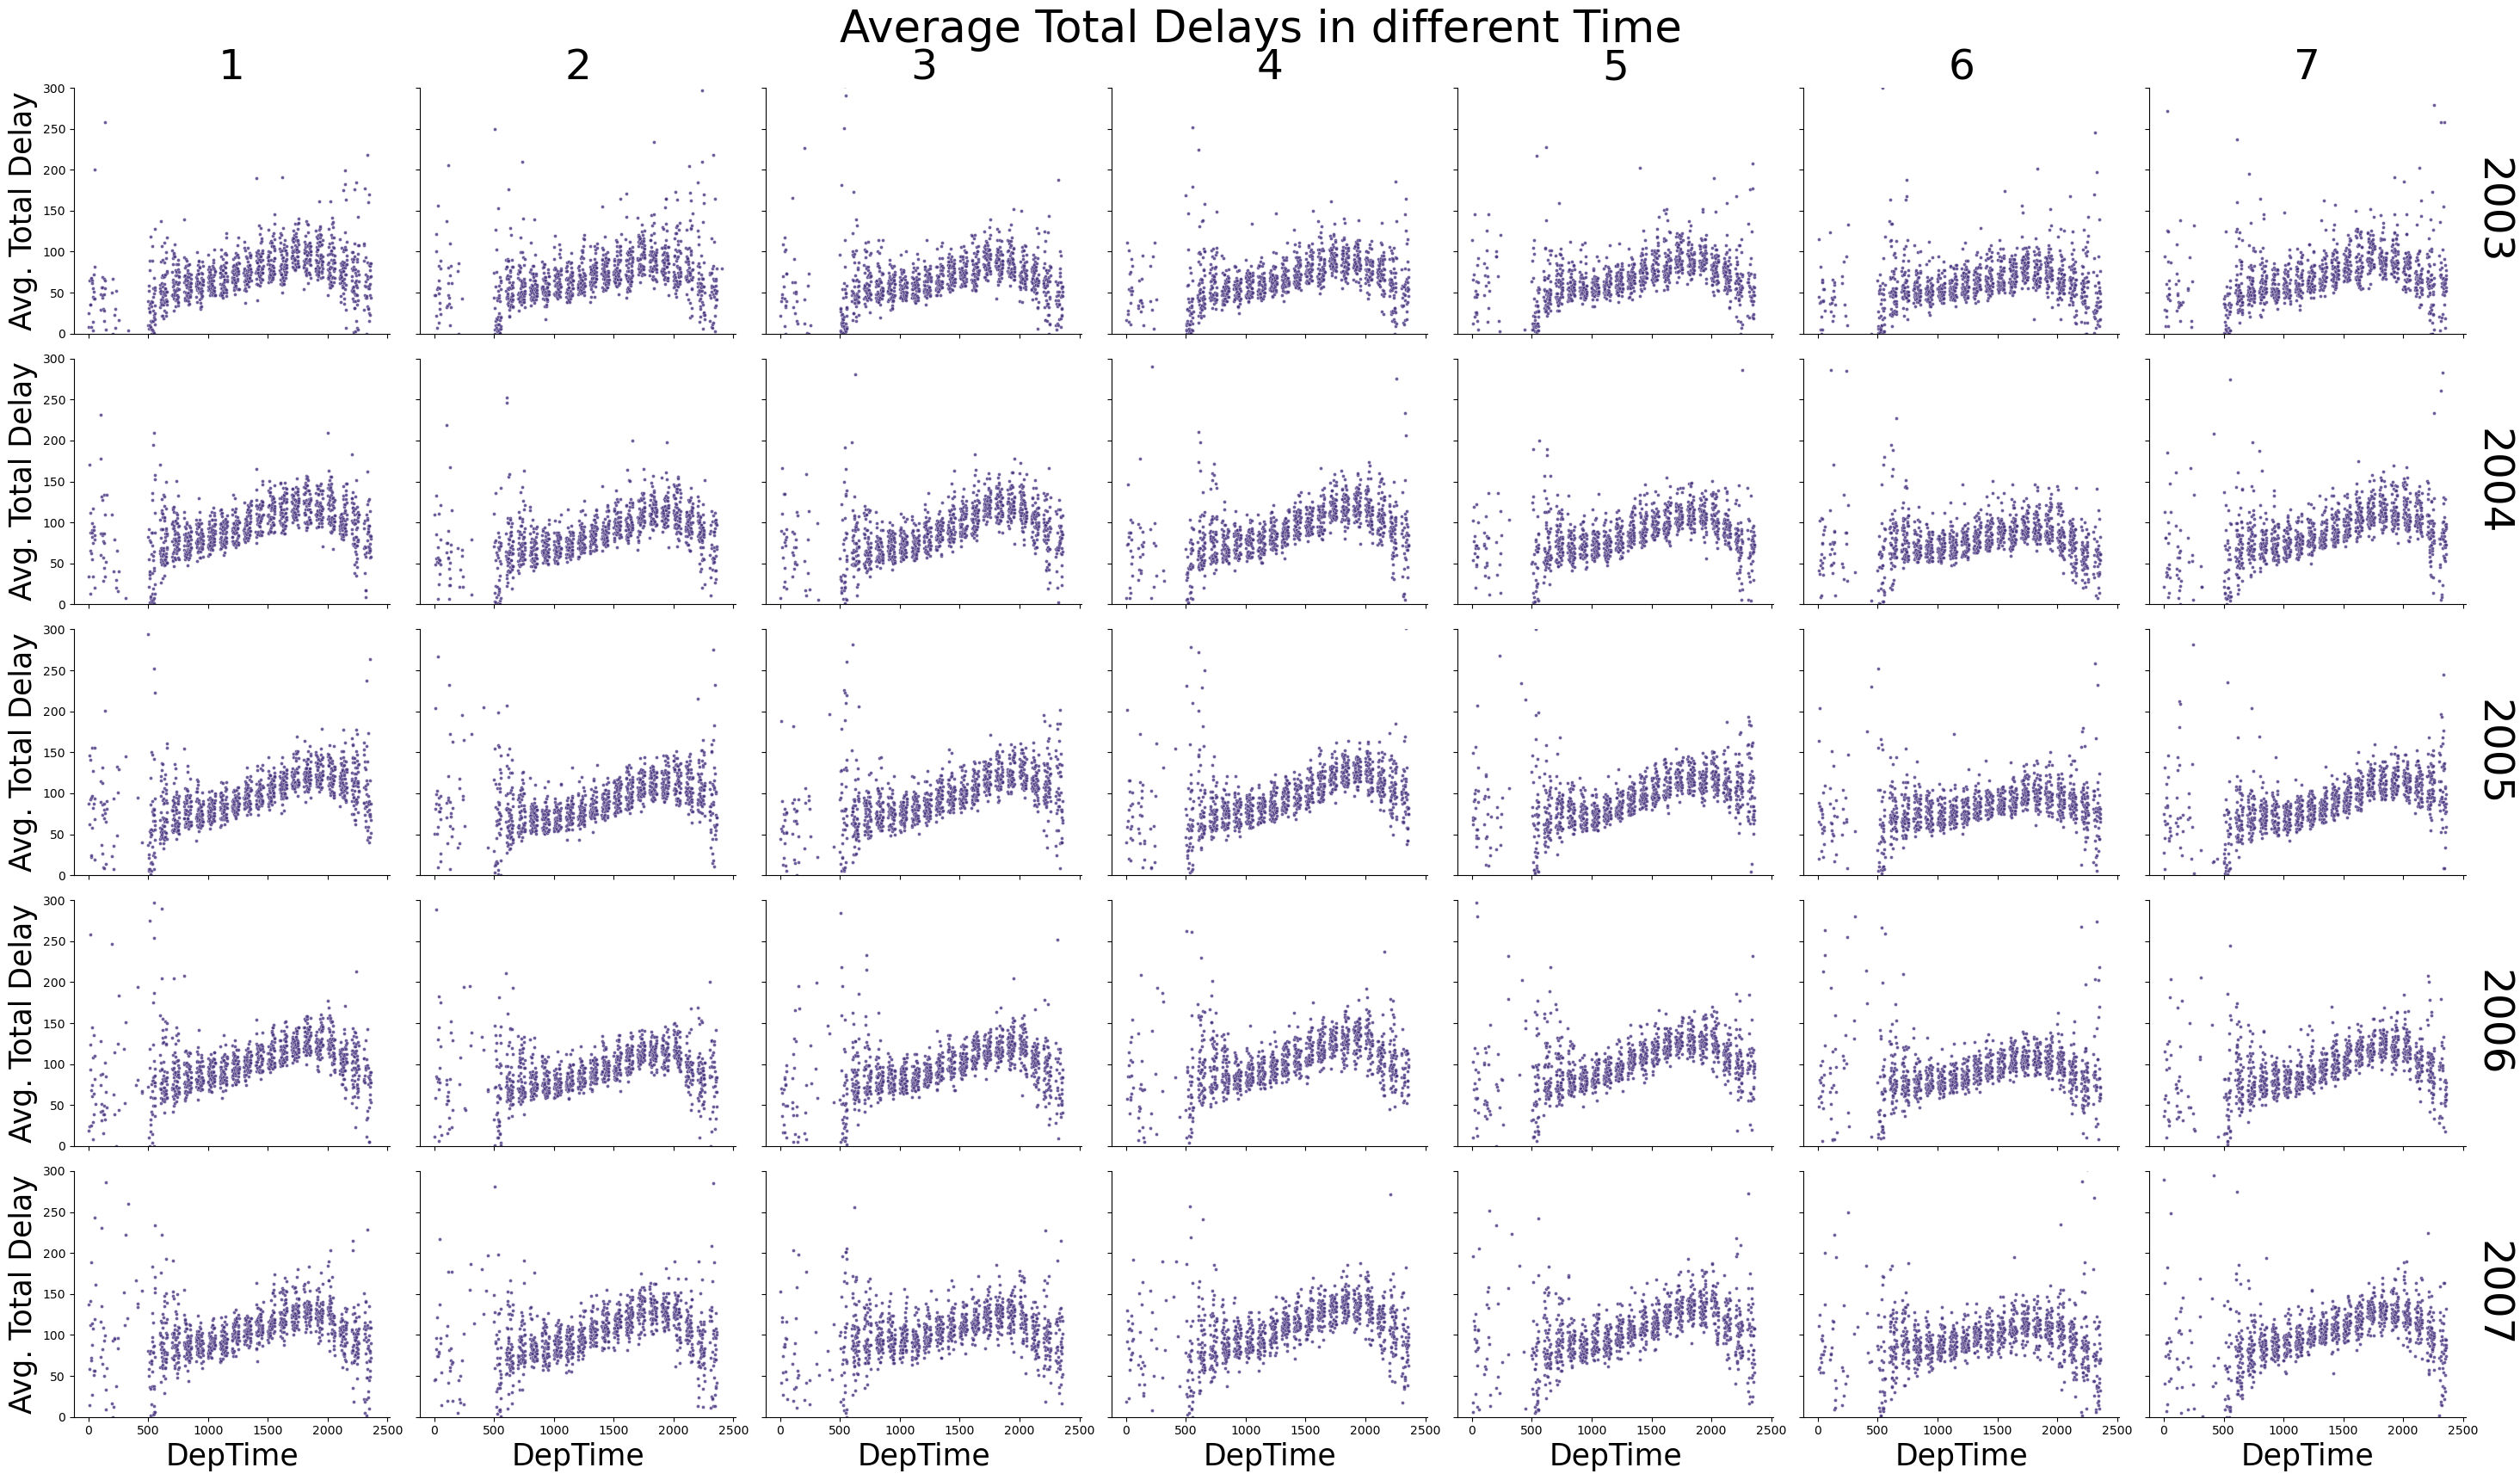

In [27]:

# Create the facet grid plot
g = sns.FacetGrid(delay_summary, col='DayOfWeek', row='Year', margin_titles=True, height=3.5, aspect=1.2)

# Map the scatter plot to the grid
g.map(sns.scatterplot, 'CRSDepTime', 'avg_TotalDelay', s=8, alpha=0.8)

# Limit y-axis to values up to 300
g.set(ylim=(0, 300))

# Add a main title
g.fig.suptitle("Average Total Delays in different Time", fontsize=37)

# Limit y-axis to values up to 300
g.set(ylim=(0, 300))

# Add titles and labels
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=35)
g.set_ylabels("Avg. Total Delay",size=25)
g.set_xlabels("DepTime",size=25)

# Show the plot
plt.tight_layout()
plt.show()

The upside-down U curve in average total delay for different time throughout the day shows that there are two points in time for each day where the average total delay is minimized. Note that the Y-axis is limited to show points with average total delay up to 300 minutes only.

I will proceed to find which time results in the lowest average total delay for each day of the week in each year.

In [13]:
best_day_time = delay_summary.loc[delay_summary.groupby(['Year', 'DayOfWeek'])['avg_TotalDelay'].idxmin()]

print(best_day_time.head())


C:\Users\steve\AppData\Local\Temp\ipykernel_22412\759078835.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_day_time = delay_summary.loc[delay_summary.groupby(['Year', 'DayOfWeek'])['avg_TotalDelay'].idxmin()]


      Year DayOfWeek  CRSDepTime  avg_TotalDelay
88    2003         1         207             0.0
1352  2003         2         207             0.0
2566  2003         3          48             0.0
3918  2003         4         503             0.0
6245  2003         5        2246             0.0


It is not yet clear which day of the week would have lower flight delays on average, since only the minimal average total delay by the exact minutes is shown, I will now find what the average total delay for the whole day is for each day of the week.

In [14]:
delay_summary_WeekDay = flight_df_filtered.groupby(['Year', 'DayOfWeek'])['TotalDelay'].mean().reset_index(name='avg_TotalDelay')

print(delay_summary_WeekDay.head())

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2953048393.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_summary_WeekDay = flight_df_filtered.groupby(['Year', 'DayOfWeek'])['TotalDelay'].mean().reset_index(name='avg_TotalDelay')


   Year DayOfWeek  avg_TotalDelay
0  2003         1       67.492481
1  2003         2       63.920105
2  2003         3       62.637329
3  2003         4       65.356652
4  2003         5       66.888823


### Final Summary Plot
To summarize it all, I will plot the overall average of total delay for the whole day as a orange line, and the exact scheduled departure time that results in the lowest average total delays as a red line. 

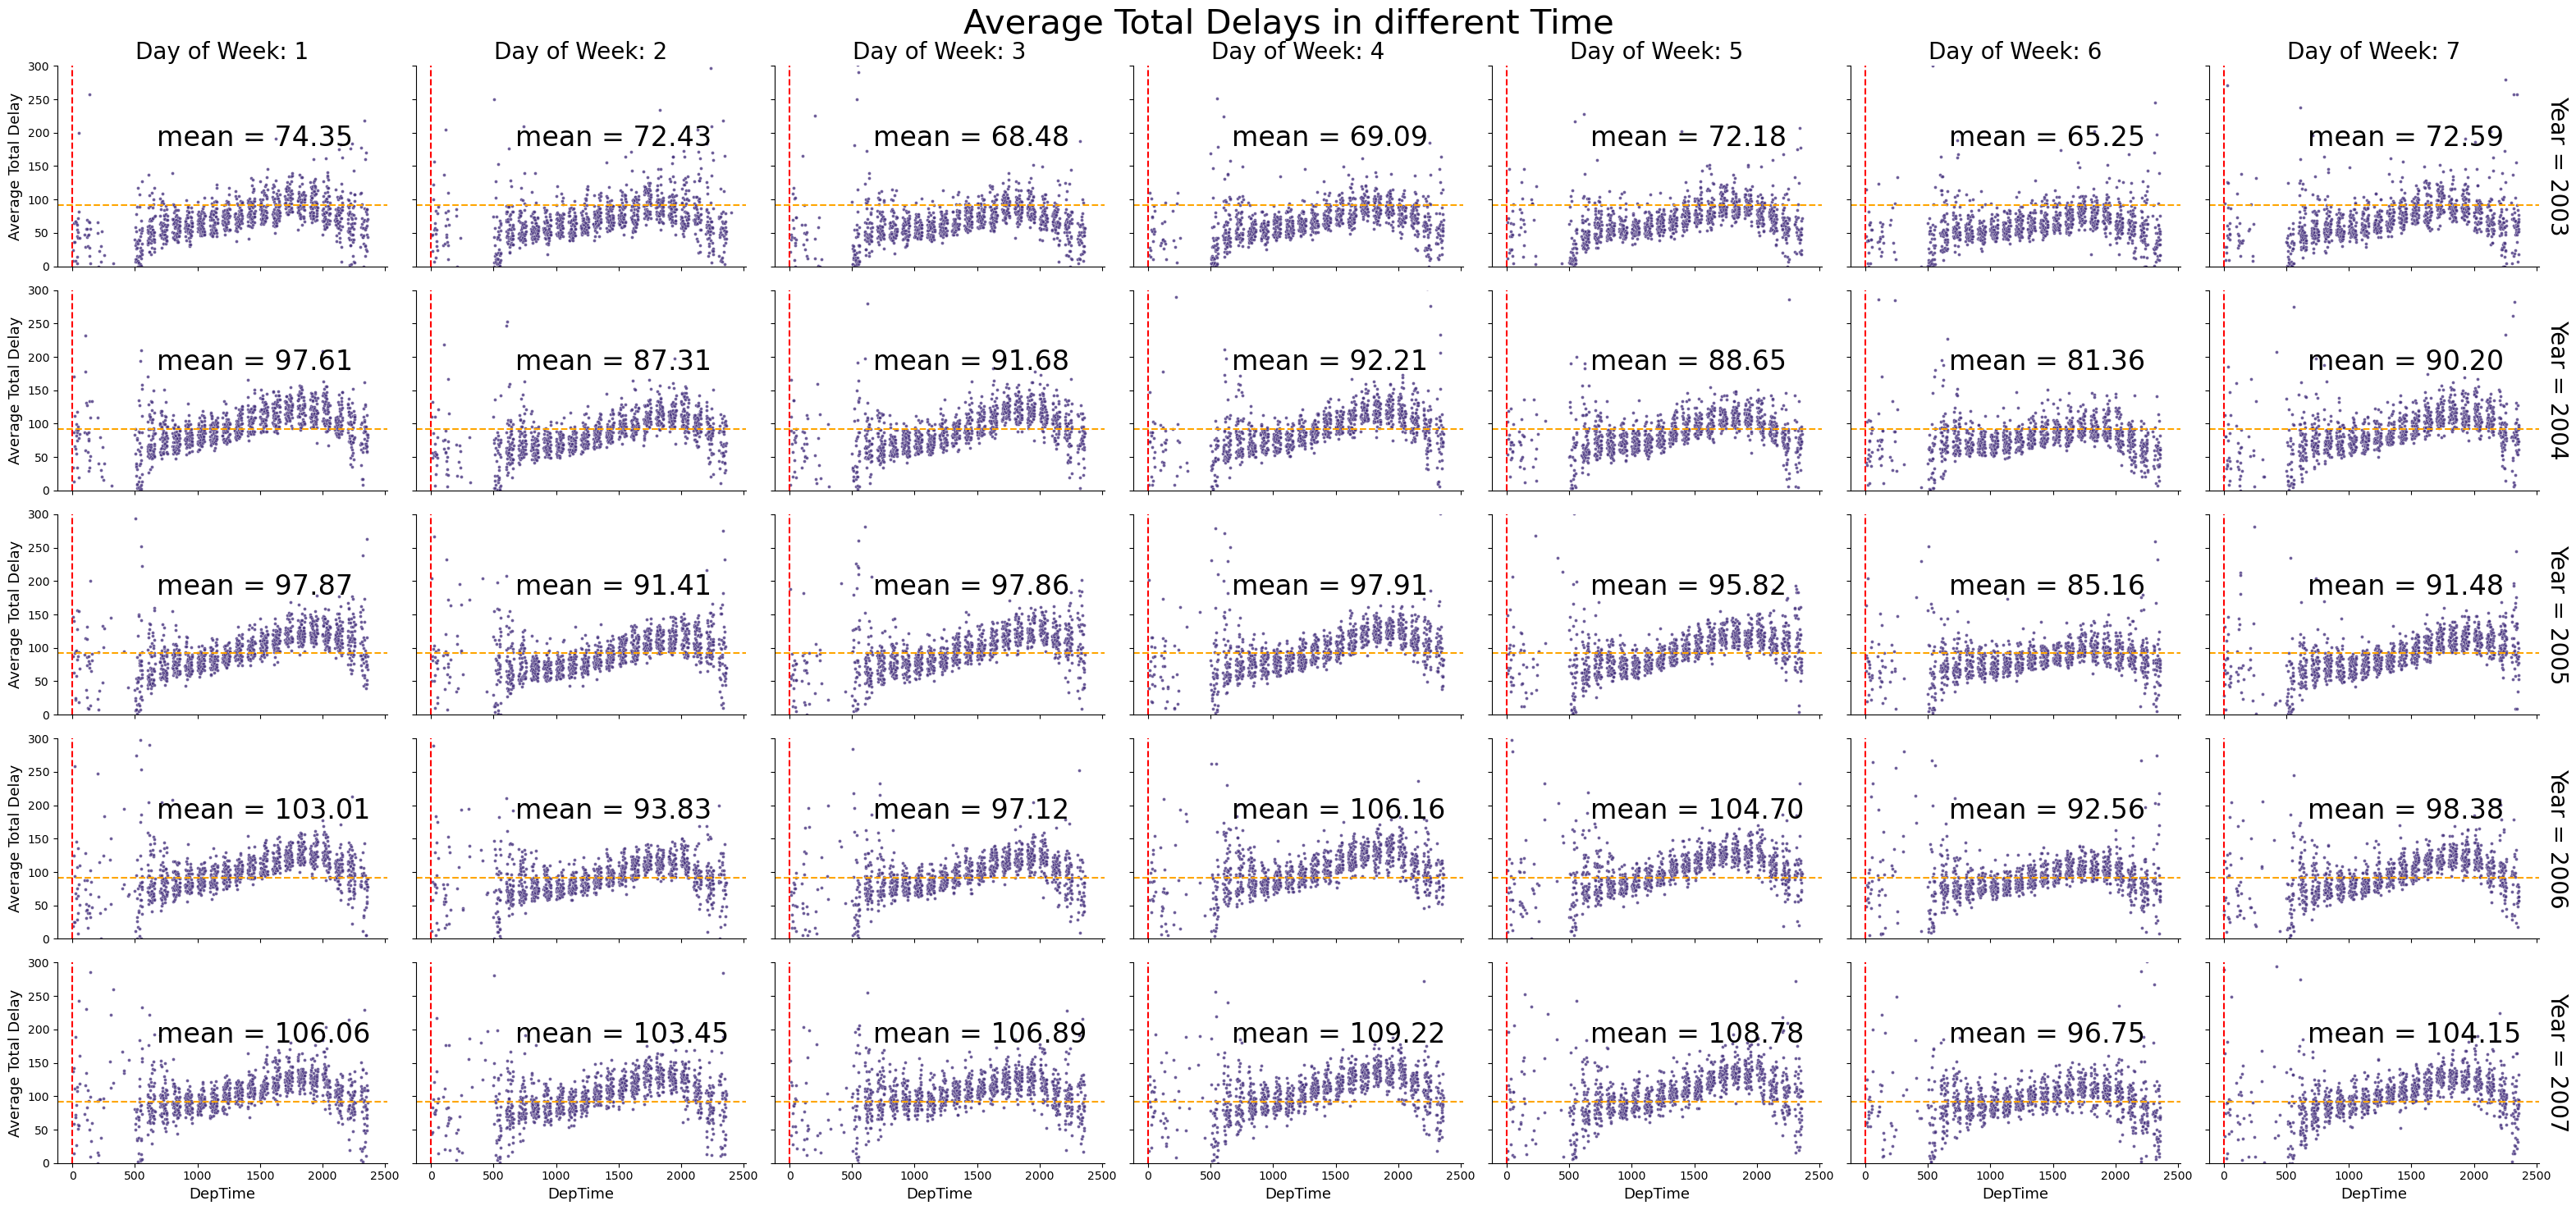

<Figure size 640x480 with 0 Axes>

In [15]:
# Final plot
# Create the facet grid plot
g = sns.FacetGrid(delay_summary, col='DayOfWeek', row='Year', margin_titles=True, height=3, aspect=1.5)

# Map the scatter plot to the grid
g.map_dataframe(sns.scatterplot, 'CRSDepTime', 'avg_TotalDelay', s=8, alpha=0.8)

# add reference lines for min value and mean value of each plots
g.refline(y=delay_summary["avg_TotalDelay"].mean(), color='orange')
g.refline(x=delay_summary["avg_TotalDelay"].min(), color='red')

def annotate(data, **kws):
    '''
    Function to add anootations for mean values of each plot
    **kws is used to ignore other keyword arguments if specified
    '''
    # mean of avg_TotalDelay for the subplot
    mean_val = data['avg_TotalDelay'].mean()
    # axis of current subplot
    ax = plt.gca()
    # add text in subplot using the ax (.1 left, .6 top)
    ax.text(.3, .6, f"mean = {mean_val:.2f}", transform=ax.transAxes,fontsize=24)

# apply the function for each facet
g.map_dataframe(annotate)

# Limit y-axis to values up to 300
g.set(ylim=(0, 300))

# Add titles and labels
g.set_titles(col_template="Day of Week: {col_name}", size=20)
g.set_ylabels("Average Total Delay",size=13)
g.set_xlabels("DepTime",size=13)


# Add a main title
g.fig.suptitle("Average Total Delays in different Time", fontsize=30)

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig("delay_scat_final.png", dpi=300)


It is shown that the time between 11:00pm and 5:30am have consistently resulted in near-zero lowest average total delays for all days of the week in all years. The orange line representing the average delays in the whole day for different weekdays shows that Saturdays have the lowest average total delay out of all weekdays for years 2003 to 2007. 

### Part 2b
For part 2b, we are interested in finding out whether older planes have more delays each year. To answer this question. The following shows step by step how I approach this question.

In [16]:
plane_df = pd.read_csv("plane-data.csv")
print(plane_df.head())

  tailnum type manufacturer issue_date model status aircraft_type engine_type  \
0  N050AA  NaN          NaN        NaN   NaN    NaN           NaN         NaN   
1  N051AA  NaN          NaN        NaN   NaN    NaN           NaN         NaN   
2  N052AA  NaN          NaN        NaN   NaN    NaN           NaN         NaN   
3  N054AA  NaN          NaN        NaN   NaN    NaN           NaN         NaN   
4  N055AA  NaN          NaN        NaN   NaN    NaN           NaN         NaN   

   year  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  


In [17]:
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        5029 non-null   object 
 1   type           4480 non-null   object 
 2   manufacturer   4480 non-null   object 
 3   issue_date     4479 non-null   object 
 4   model          4480 non-null   object 
 5   status         4480 non-null   object 
 6   aircraft_type  4480 non-null   object 
 7   engine_type    4477 non-null   object 
 8   year           4335 non-null   float64
dtypes: float64(1), object(8)
memory usage: 353.7+ KB


In [18]:
plane_df.describe(include='all')

tailnum         type manufacturer  issue_date        model status  \
count     5029         4480         4480        4479         4480   4480   
unique    5029            5           39        2412          167      2   
top     N050AA  Corporation       BOEING  12/22/1986  CL-600-2B19  Valid   
freq         1         4440         2061          33          403   4479   
mean       NaN          NaN          NaN         NaN          NaN    NaN   
std        NaN          NaN          NaN         NaN          NaN    NaN   
min        NaN          NaN          NaN         NaN          NaN    NaN   
25%        NaN          NaN          NaN         NaN          NaN    NaN   
50%        NaN          NaN          NaN         NaN          NaN    NaN   
75%        NaN          NaN          NaN         NaN          NaN    NaN   
max        NaN          NaN          NaN         NaN          NaN    NaN   

                  aircraft_type engine_type         year  
count                      4480        4477  4335.000000  
unique                        4           6          NaN  
top     Fixed Wing Multi-Engine   Turbo-Fan          NaN  
freq                       4440        2883          NaN  
mean                        NaN         NaN  1995.523414  
std                         NaN         NaN    53.062382  
min                         NaN         NaN     0.000000  
25%                         NaN         NaN  1992.000000  
50%                         NaN         NaN  1999.000000  
75%                         NaN         NaN  2002.000000  
max                         NaN         NaN  2008.000000

There are 549 planes with missing data across all columns except for `tailnum`, I will remove these observations as there are no usable information here.

In [19]:
# Remove rows with missing data in 'Type' and 'year'
plane_df_filtered = plane_df.dropna(subset=['type','year'])

print(plane_df_filtered.head())

   tailnum         type      manufacturer  issue_date      model status  \
34  N10156  Corporation           EMBRAER  02/13/2004  EMB-145XR  Valid   
35  N102UW  Corporation  AIRBUS INDUSTRIE  05/26/1999   A320-214  Valid   
36  N10323  Corporation            BOEING  07/01/1997    737-3TO  Valid   
37  N103US  Corporation  AIRBUS INDUSTRIE  06/18/1999   A320-214  Valid   
38  N104UA  Corporation            BOEING  01/26/1998    747-422  Valid   

              aircraft_type engine_type    year  
34  Fixed Wing Multi-Engine   Turbo-Fan  2004.0  
35  Fixed Wing Multi-Engine   Turbo-Fan  1998.0  
36  Fixed Wing Multi-Engine   Turbo-Jet  1986.0  
37  Fixed Wing Multi-Engine   Turbo-Fan  1999.0  
38  Fixed Wing Multi-Engine   Turbo-Fan  1998.0  


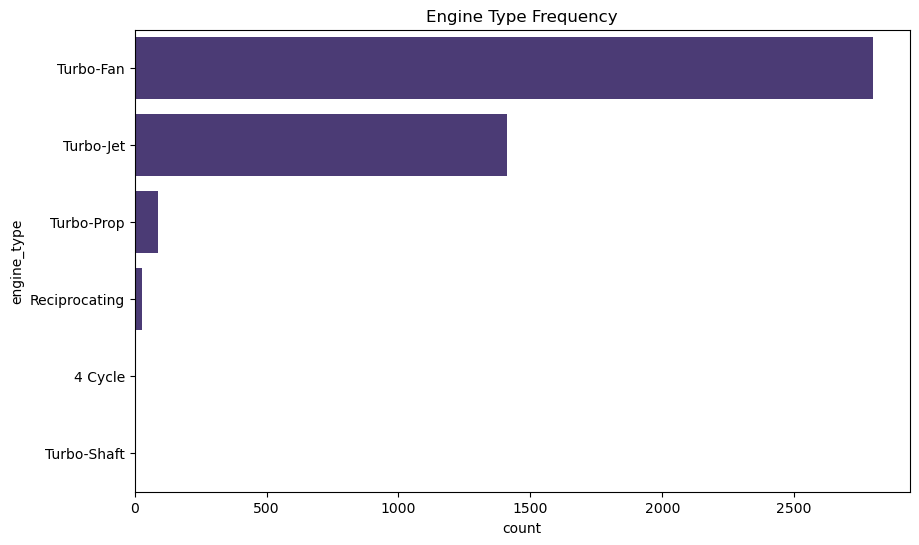

In [20]:
# Plot bar chart for engine type frequency
plt.figure(figsize=(10, 6))
sns.countplot(y='engine_type', data=plane_df_filtered, order=plane_df_filtered['engine_type'].value_counts().index)
plt.title('Engine Type Frequency')
plt.show()

In [21]:
# Display unique manufacturers
print(plane_df_filtered['manufacturer'].unique())

['EMBRAER' 'AIRBUS INDUSTRIE' 'BOEING' 'DOUGLAS' 'MCDONNELL DOUGLAS'
 'CANADAIR' 'BOMBARDIER INC' 'AIRBUS' 'CESSNA' 'SAAB-SCANIA' 'BEECH'
 'SIKORSKY' 'GULFSTREAM AEROSPACE' 'PIPER' 'AGUSTA SPA' 'AERO COMMANDER'
 'AVIAT AIRCRAFT INC' 'RAVEN' 'DEHAVILLAND' 'WOBIG WAYNE R' 'BELL'
 'FRIEDEMANN JON' 'STINNETT RON' 'HELIO' 'LEBLANC GLENN T' 'MARZ BARRY'
 'MORSE GEORGE JR' 'AEROSPATIALE/ALENIA' 'DIAMOND AIRCRAFT IND INC'
 'BOEING OF CANADA LTD' 'MCDONNELL DOUGLAS CORPORATION'
 'MCDONNELL DOUGLAS AIRCRAFT CO' 'COBB INTL/DBA ROTORWAY INTL IN'
 'AERONCA' 'MAULE']


In [22]:
# Display unique values in the 'status' column
print(plane_df_filtered['status'].value_counts())

status
Valid                4334
Registered to Mfr       1
Name: count, dtype: int64


There is one plane with `status` not valid, I will it.

In [23]:
# Keep rows that are valid
plane_df_filtered = plane_df_filtered[plane_df_filtered['status'] == 'Valid']

print(plane_df_filtered['status'].value_counts())

status
Valid    4334
Name: count, dtype: int64


As there were no documentation explaining what is meant by `issue_date` or `year`, I will assume the `year` column contains information about the manufactured year of a plane, and `issue_date` is when the plane has officially entered service, since based on observation, the `year` is always before `issue_date` in this dataset. 

I will convert some variables into categorical type, and remove some features that may not be relevant for subsequent analysis.

In [24]:
# Select relevant columns and convert to category
plane_df_filtered = plane_df_filtered.drop(columns=['manufacturer', 'model', 'status', 'issue_date'])

plane_df_filtered['type'] = plane_df_filtered['type'].astype('category')
plane_df_filtered['engine_type'] = plane_df_filtered['engine_type'].astype('category')
plane_df_filtered['aircraft_type'] = plane_df_filtered['aircraft_type'].astype('category')

In [25]:
plane_df_filtered['year'].value_counts().sort_values()

year
1971.0      1
1956.0      1
1972.0      1
1962.0      1
1966.0      1
1964.0      1
1965.0      1
1946.0      1
1957.0      1
1970.0      2
1974.0      2
1963.0      2
1959.0      2
1973.0      3
0.0         3
1977.0      6
1982.0      6
1978.0      8
1976.0      8
1980.0      8
1975.0     10
1979.0     11
1969.0     12
1967.0     16
1983.0     18
1968.0     24
1984.0     27
2008.0     37
1985.0     84
1986.0     92
1993.0    100
1995.0    101
1994.0    103
2007.0    106
1996.0    109
1989.0    110
1987.0    131
1997.0    134
1990.0    145
1992.0    146
1988.0    148
2006.0    152
1991.0    156
2005.0    193
2004.0    240
1998.0    248
2003.0    266
2002.0    306
1999.0    320
2000.0    341
2001.0    389
Name: count, dtype: int64

In [26]:
plane_df_filtered.isna().sum()

tailnum          0
type             0
aircraft_type    0
engine_type      2
year             0
dtype: int64

There are some planes with `year` as 0000, and some with NA `engine_type`, I will remove those observations.

In [27]:
# Remove planes with year as 0.0
plane_df_filtered = plane_df_filtered[(plane_df_filtered['year'] != 0) & (plane_df_filtered['engine_type'].isna() == False)]

In [28]:
plane_df_filtered.isna().sum()

tailnum          0
type             0
aircraft_type    0
engine_type      0
year             0
dtype: int64

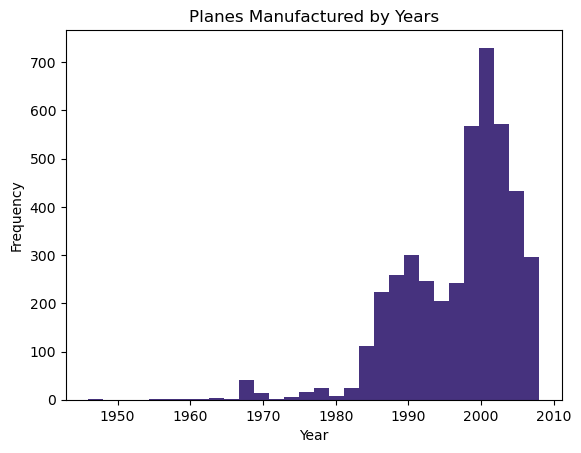

In [29]:
# Plot histogram of plane years
plt.hist(plane_df_filtered['year'], bins=30)
plt.title('Planes Manufactured by Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

The column `TailNum` from the flight data and `tailnum` from the plane data can be used as key index to join both sides of the data and select the needed features for this problem. Since this question requires both information of the flights and the plane data, I will use an inner-join method to make sure both sides of the data are present.

The same filtered and cleaned flight data from part 2a will be used in this part.

In [30]:
# Join flight and plane data
flight_plane = flight_df_filtered.merge(plane_df_filtered, how='inner', left_on='TailNum', right_on='tailnum')
print(flight_plane.head())

   Year  Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2003      1           2         4     1053        1035     1726   
1  2003      1           5         7     1035        1035     1636   
2  2003      1           1         3     1713        1710     1851   
3  2003      1           5         7     1832        1710     1951   
4  2003      1          26         7     1748        1710     1941   

   CRSArrTime UniqueCarrier  FlightNum  ... WeatherDelay  NASDelay  \
0        1634            UA       1018  ...            0         0   
1        1634            UA       1018  ...            0         0   
2        1847            UA       1020  ...            0         0   
3        1847            UA       1020  ...            0         0   
4        1847            UA       1020  ...            0         0   

   SecurityDelay  LateAircraftDelay  TotalDelay  tailnum         type  \
0              0                  0          70   N496UA  Corporation   
1           

In [31]:
flight_plane.shape

(8623125, 35)

I will use the `year` column from the plane data to calculate the age of a plane as of its departure date in the flight data (`Year` - `year`).
-  `Year` is from the flight data, represents year of flight departure.
-  `year` is from the plane data, represents manufacture year of a plane.

In [32]:
# Calculate plane age
flight_plane['PlaneAge'] = flight_plane['Year'] - flight_plane['year']

flight_plane[['Year','year','PlaneAge']].head()

Year    year  PlaneAge
0  2003  2002.0       1.0
1  2003  1999.0       4.0
2  2003  1992.0      11.0
3  2003  1992.0      11.0
4  2003  1992.0      11.0

In [33]:
flight_plane[['Year','year','PlaneAge']].describe()

Year          year   PlaneAge
count    8623125.0  8.623125e+06  8623125.0
mean   2005.381361  1.996279e+03   9.102803
std       1.352695  7.136927e+00    7.12661
min         2003.0  1.956000e+03       -4.0
25%         2004.0  1.992000e+03        4.0
50%         2006.0  1.998000e+03        7.0
75%         2007.0  2.002000e+03       14.0
max         2007.0  2.007000e+03       51.0

There are some observations with `PlaneAge` below zero, which means the manufactured `year` from plane data is more recent than the `Year` of flight departure from the flight data. More information may be needed to explain the reasons behind this. For now, I will exclude these observations and proceed with the next steps of the analysis.

In [34]:
# Remove negative plane age
flight_plane_filtered = flight_plane[flight_plane['PlaneAge'] >= 0]

In [35]:
flight_plane_filtered[['Year','year','PlaneAge']].describe()

Year          year   PlaneAge
count    8621291.0  8.621291e+06  8621291.0
mean   2005.381522  1.996276e+03   9.105245
std       1.352699  7.135973e+00   7.125383
min         2003.0  1.956000e+03        0.0
25%         2004.0  1.992000e+03        4.0
50%         2006.0  1.998000e+03        7.0
75%         2007.0  2.002000e+03       14.0
max         2007.0  2.007000e+03       51.0

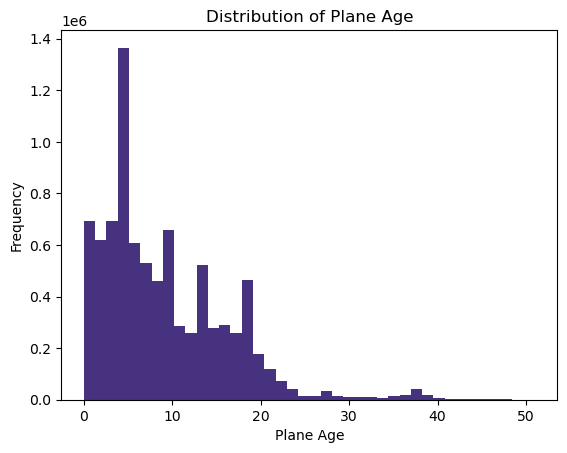

In [36]:
# Plot histogram of plane age
plt.hist(flight_plane_filtered['PlaneAge'], bins=40)
plt.title('Distribution of Plane Age')
plt.xlabel('Plane Age')
plt.ylabel('Frequency')
plt.show()

Line plot of average total delays by plane age

Text(0.5, 1.0, 'Trend of Overall Average Total Delay by Plane Age')

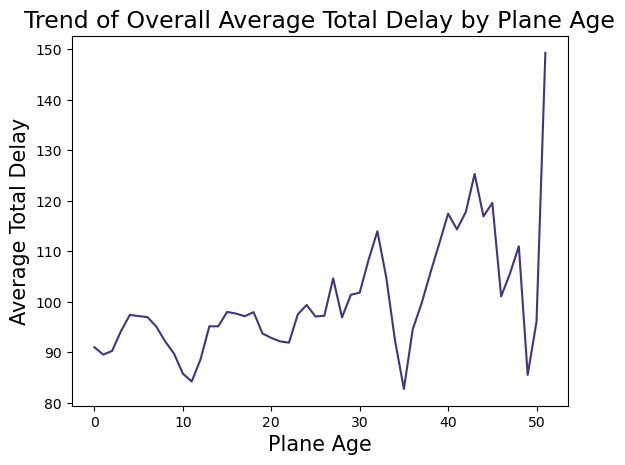

In [37]:
planeAge_summary = flight_plane_filtered.groupby('PlaneAge').agg(AvgTotalDelay = ('TotalDelay',"mean")).reset_index()

sns.lineplot(planeAge_summary, x = 'PlaneAge', y = 'AvgTotalDelay')
# Labels and title
plt.xlabel("Plane Age", fontsize= 15)
plt.ylabel("Average Total Delay", fontsize = 15)
plt.title("Trend of Overall Average Total Delay by Plane Age", fontsize=17)

Same plot, but a line for each year individually

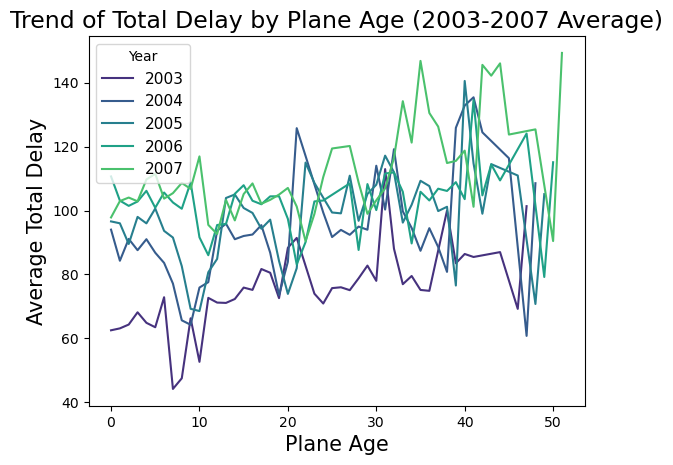

In [38]:
for i in flight_plane_filtered['Year'].unique():
    year_subset = flight_plane_filtered[flight_plane_filtered['Year'] == i]
    planeAge_summary = year_subset.groupby('PlaneAge').agg(AvgTotalDelay = ('TotalDelay',"mean")).reset_index()

    sns.lineplot(planeAge_summary, x = 'PlaneAge', y = 'AvgTotalDelay',label=f"{i}")

# Labels and title
plt.xlabel("Plane Age",fontsize=15)
plt.ylabel("Average Total Delay",fontsize=15)
plt.title("Trend of Total Delay by Plane Age (2003-2007 Average)",fontsize=17)

# Add legend
plt.legend(title="Year",fontsize=11)

# Show plot

plt.show()

Most of the planes has operated for under 10 years as of their departure year. There are not much planes over 20 years old. There appears to be an upward trend of average total delays as plane age increases. Additionally, there are spikes that are either upwards or downwards in average total delay observed at approximately every 10-year interval (ages 10, 20, 30, 40, and 50).

To better highlight these spikes in delay for plane age near the boundaries of the intervals, I will create a new categorical from the `PlaneAge` variable by cutting it into 4 levels of age, 0-5, 6-10, 11-20, and 21+ using the `cut()` method from pandas. I will then create boxplots to visualize the average levels of delay of planes under these 4 levels of plane age.

In [39]:
# Convert PlaneAge to categorical variable
flight_plane_filtered['PlaneAgeCategory'] = pd.cut(flight_plane_filtered['PlaneAge'], 
                                                   bins=[0, 7, 12, 17, 22, 27, 32, 37, 42, 47, 50], 
                                                   labels=["0-7", "8-12", "13-17", "18-22", "23-27", 
                                                           "28-32", "33-37", "38-42", "43-47", "48-50"],
                                                   right=True)  # right endpoint

# Check the distribution of the categories
print(flight_plane_filtered['PlaneAgeCategory'].value_counts())


PlaneAgeCategory
0-7      4321797
8-12     1660681
13-17    1347588
18-22     834277
23-27      86529
33-37      63050
28-32      59793
38-42      51584
43-47       6436
48-50       2074
Name: count, dtype: int64


C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2748393328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_plane_filtered['PlaneAgeCategory'] = pd.cut(flight_plane_filtered['PlaneAge'],


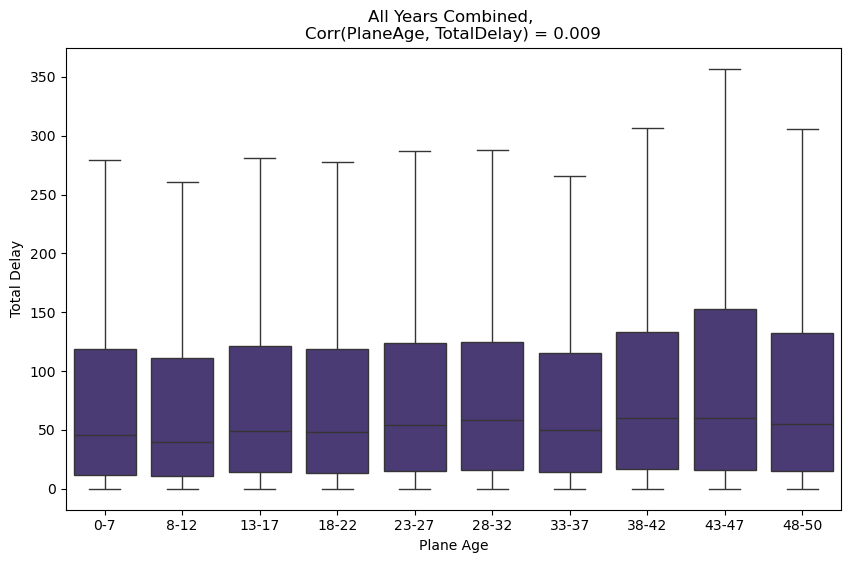

In [40]:
# Compute correlation between plane age and total delay
corr_value = flight_plane_filtered['PlaneAge'].corr(flight_plane_filtered['TotalDelay'])
# Plot boxplot of total delay by plane age category (without showing outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(x='PlaneAgeCategory', y='TotalDelay', data=flight_plane_filtered, showfliers=False)
plt.title(f'All Years Combined, \nCorr(PlaneAge, TotalDelay) = {corr_value:.3f}')
plt.xlabel('Plane Age')
plt.ylabel('Total Delay')
plt.show()


The boxplot and the low correlation coefficient value between TotalDelay and PlaneAge for all years combined suggest that there is little linear correlation between plane age and total delays. 

To further investigate the correlation between these two variables each year, I will create separate plots and compute the correlation coefficient for each year individually.

Seperate box plot for each year

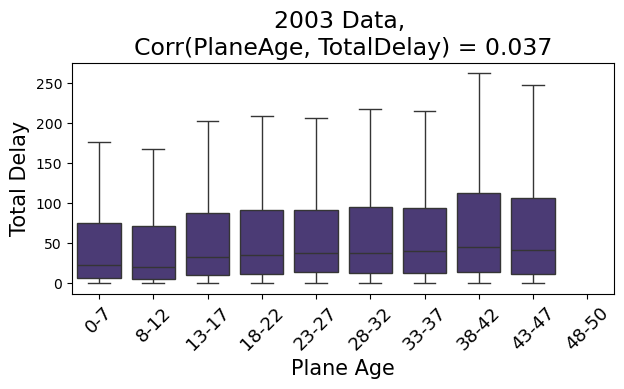

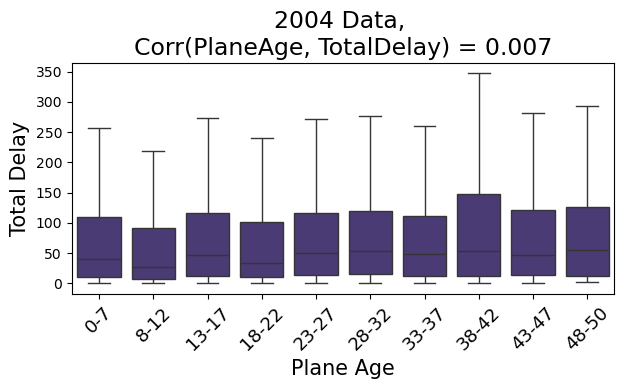

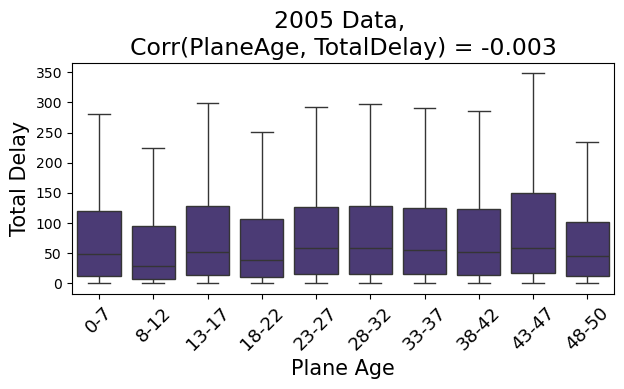

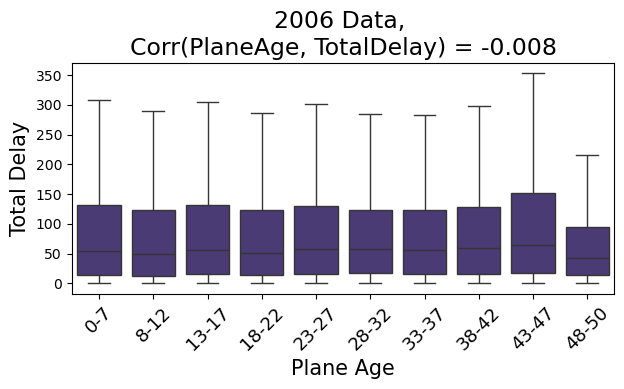

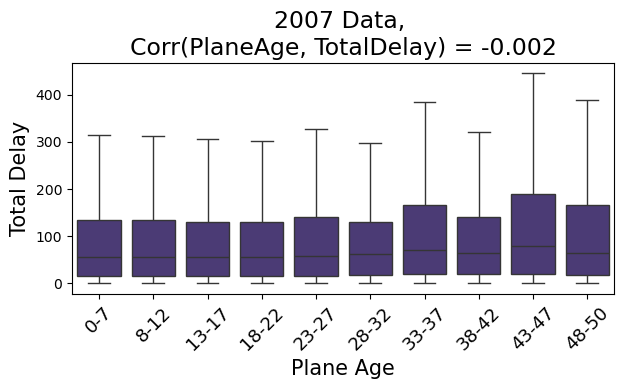

In [41]:
for i in flight_plane_filtered['Year'].unique():
    year_subset = flight_plane_filtered[flight_plane_filtered['Year'] == i]
    # Compute correlation between plane age and total delay in subset year
    corr_value = year_subset['PlaneAge'].corr(year_subset['TotalDelay'])
    # Plot boxplot of log total delay by plane age category
    plt.figure(figsize=(7, 3))
    sns.boxplot(x='PlaneAgeCategory', y='TotalDelay', data=year_subset, showfliers=False)
    plt.title(f'{i:.0f} Data, \nCorr(PlaneAge, TotalDelay) = {corr_value:.3f}', fontsize =17)
    plt.xlabel('Plane Age',fontsize=15)
    plt.ylabel('Total Delay',fontsize=15)
    plt.xticks(rotation=45, fontsize=13)
    plt.show()

When separated into individual years, the correlation between `TotalDelay` and `PlaneAge` remains close to zero. Additionally, the boxplots for different plane age categories show mean and quartile ranges that are nearly the same across each year despite a upward trend observed in previous line plot. This suggests that while plane age doesn’t have a clear linear connection to delays, extreme delays in older planes (e.g., 10, 20, or 30 years old) can occasionally push up the average, even though the overall pattern remains stable.

### Part 2c
For this part, we are interested in predicting the probability of diverted flights given some selected features in a logistic regression model. 

I will begin by investigating the carriers data and airports data. The data from part b `flight_plane.filtered`, which has already filtered out cancelled flights, flights with negative plane age, and flights with no plane data, will be used to join both the carriers and airports data.

In [42]:
# Import carriers and airports data
airport_df = pd.read_csv('airports.csv')
carriers_df = pd.read_csv('carriers.csv')

In [43]:
carriers_df.head()

Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.

Rename 'Description' as 'CarrierName'

In [44]:
carriers_df = carriers_df.rename(columns={"Description": "CarrierName"})

Based on observation, the variables `Origin` and `Dest` from the flights data and `iata` from the airports data can be used as common keys to join these datasets. Additionally, the `Code` variable from the carriers data and the `UniqueCarrier` variable from the flights data are also matching keys that can be used to join these datasets together.

I will add in `lat` and `long` from airports data to provide coordinates of Origin and Destination airports in the flight data. The extra description from the carrier data will not be used because I did not find it useful in anyway for this part.

In [45]:
# Join flight, plane, carrier, and airport data into one df
flight_plane_airport = flight_plane_filtered.merge(airport_df[['iata', 'lat', 'long']], left_on='Origin', right_on='iata', how='left')
flight_plane_airport = flight_plane_airport.merge(airport_df[['iata', 'lat', 'long']], left_on='Dest', right_on='iata', how='left', suffixes=('', '_dest'))
flight_plane_airport = flight_plane_airport.merge(carriers_df[['Code','CarrierName']], left_on='UniqueCarrier', right_on='Code', how='left')

print(flight_plane_airport.head())

   Year  Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2003      1           2         4     1053        1035     1726   
1  2003      1           5         7     1035        1035     1636   
2  2003      1           1         3     1713        1710     1851   
3  2003      1           5         7     1832        1710     1951   
4  2003      1          26         7     1748        1710     1941   

   CRSArrTime UniqueCarrier  FlightNum  ... PlaneAge  PlaneAgeCategory  iata  \
0        1634            UA       1018  ...      1.0               0-7   OAK   
1        1634            UA       1018  ...      4.0               0-7   OAK   
2        1847            UA       1020  ...     11.0              8-12   IAD   
3        1847            UA       1020  ...     11.0              8-12   IAD   
4        1847            UA       1020  ...     11.0              8-12   IAD   

         lat        long  iata_dest   lat_dest  long_dest  Code  \
0  37.721291 -122.220717       

In [46]:
flight_plane_airport['Diverted'].value_counts()

Diverted
False    8587700
True       33591
Name: count, dtype: int64

There are significant class imbalance in the target variable. 

### Carrier impact on divertion
`UniqueCarrier` will be converted into a categorical variable. The following table summarises the average carrier delay based on different carriers.

In [47]:
# Convert UniqueCarrier to category
flight_plane_airport['UniqueCarrier'] = flight_plane_airport['UniqueCarrier'].astype('category')

# Display average carrier delay by carrier
carrier_delay = flight_plane_airport.groupby(['Year','UniqueCarrier','CarrierName']).agg({'Diverted': ['sum', 'mean']}).reset_index()
carrier_delay.columns = ['Year','UniqueCarrier','CarrierName','DivertedCount', 'DivertedPct']
carrier_delay = carrier_delay.sort_values(by='DivertedCount', ascending=False)
print(carrier_delay.head(20))

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2728883251.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carrier_delay = flight_plane_airport.groupby(['Year','UniqueCarrier','CarrierName']).agg({'Diverted': ['sum', 'mean']}).reset_index()


      Year UniqueCarrier                                        CarrierName  \
2160  2007            WN                             Southwest Airlines Co.   
1732  2006            XE                           Expressjet Airlines Inc.   
2021  2007            MQ                       American Eagle Airlines Inc.   
2173  2007            XE                           Expressjet Airlines Inc.   
1580  2006            MQ                       American Eagle Airlines Inc.   
576   2004            DL                               Delta Air Lines Inc.   
1017  2005            DL                               Delta Air Lines Inc.   
1768  2007            AA                             American Airlines Inc.   
1679  2006            UA                              United Air Lines Inc.   
1458  2006            DL                               Delta Air Lines Inc.   
2140  2007            US  US Airways Inc. (Merged with America West 9/05...   
1278  2005            WN                            

It is mentioned in the carrier description that America West Airlines Inc. and US Airways Inc. have merged in 9/05 (Sep, 2005), which means flight records with carrier belonging to these two airlines should have the same Carrier name after this date. I will proceed to Rename these carriers to 'US/America West merged'.

First I have to derive a new datetime variable using the 'Year', 'Month', 'DayofMonth', and 'DepTime' variables together.

In [48]:
flight_plane_airport[flight_plane_airport['DepTime'].astype(int) > 2400]['DepTime'].describe()

count         2853.0
mean     2451.174203
std        57.563942
min           2401.0
25%           2412.0
50%           2430.0
75%           2455.0
max           2930.0
Name: DepTime, dtype: Float64

In [49]:
flight_plane_airport[flight_plane_airport['DepTime'].astype(int) > 2400]['DepTime'].value_counts()

DepTime
2410    166
2405    150
2420    132
2415    124
2430    106
       ... 
2658      1
2805      1
2635      1
2722      1
2930      1
Name: count, Length: 171, dtype: Int64

There are some records with 'DepTime' over 24:00. It is not clear what these record meant, more information is needed to correctly treat it, but for now I will cap the departure time to 23:59 to prevent issues in converting to datetime format.

In [50]:
# cap 'DepTime' to 2359
flight_plane_airport['DepTime'] = flight_plane_airport['DepTime'].astype(int)
mask = (flight_plane_airport['DepTime'] >= 2400)
flight_plane_airport.loc[mask, 'DepTime'] = 2359

# change variables to type str first
# zfill to pad the strings with leading zeros so it is in correct length
flight_plane_airport['Year'] = flight_plane_airport['Year'].astype(str).str.zfill(4) 
flight_plane_airport['Month'] = flight_plane_airport['Month'].astype(str).str.zfill(2)
flight_plane_airport['DayofMonth'] = flight_plane_airport['DayofMonth'].astype(str).str.zfill(2)
flight_plane_airport['DepTime'] = flight_plane_airport['DepTime'].astype(str).str.zfill(4)

# Extract hour and minute (this are temporary columns)
flight_plane_airport['Hour'] = flight_plane_airport['DepTime'].str[:2]
flight_plane_airport['Minute'] = flight_plane_airport['DepTime'].str[2:4]

In [51]:
flight_plane_airport[flight_plane_airport['Minute'].astype(int) > 60]

Year Month DayofMonth DayOfWeek DepTime  CRSDepTime  ArrTime  \
317167  2003    04         23         3    0095        1142       51   

        CRSArrTime UniqueCarrier  FlightNum  ... iata        lat        long  \
317167        1228            AS         62  ...  SIT  57.047138 -135.361598   

        iata_dest   lat_dest  long_dest Code           CarrierName  Hour  \
317167        KTN  55.355569 -131.71374   AS  Alaska Airlines Inc.    00   

        Minute  
317167      95  

[1 rows x 47 columns]

This record contains departure time of 00:95, this does not make sense and would prevent datetime conversion, I will change this to 01:00 instead.

In [52]:
flight_plane_airport.loc[317167, 'Hour'] = '01'
flight_plane_airport.loc[317167, 'Minute'] = '00'

In [53]:
# Combine into datetime format
flight_plane_airport['DepTime.dt'] = pd.to_datetime(
    flight_plane_airport['Year'] + '-' +
    flight_plane_airport['Month'] + '-' +
    flight_plane_airport['DayofMonth'] + '-' +
    flight_plane_airport['Hour'] + '-' +
    flight_plane_airport['Minute'],
    format='%Y-%m-%d-%H-%M'
)

# Drop temporary columns
flight_plane_airport.drop(columns=['Hour', 'Minute'], inplace=True)

# check result
print(flight_plane_airport[['DepTime.dt', 'Year', 'Month', 'DayofMonth', 'DepTime']].head())


           DepTime.dt  Year Month DayofMonth DepTime
0 2003-01-02 10:53:00  2003    01         02    1053
1 2003-01-05 10:35:00  2003    01         05    1035
2 2003-01-01 17:13:00  2003    01         01    1713
3 2003-01-05 18:32:00  2003    01         05    1832
4 2003-01-26 17:48:00  2003    01         26    1748


Rename carriers to 'US/America West merged' based on specified condition.

In [54]:
# 1. Merge the two carriers if the departure date is on/after 2005-09-01
flight_plane_airport['CarrierName'] = np.where(
    (flight_plane_airport['DepTime.dt'] >= pd.to_datetime("2005-09-01")) &
    (flight_plane_airport['CarrierName'].isin([
        'US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)',
        'America West Airlines Inc. (Merged with US Airways 9/05. Stopped reporting 10/07.)'
    ])),
    'US/America West merged',
    flight_plane_airport['CarrierName']
)

# 2. For departures before 2005-09-01, set the US Airways name
flight_plane_airport['CarrierName'] = np.where(
    (flight_plane_airport['DepTime.dt'] < pd.to_datetime("2005-09-01")) &
    (flight_plane_airport['CarrierName'] == 'US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)'),
    'US Airways Inc.',
    flight_plane_airport['CarrierName']
)

# 3. Set for the America West name
flight_plane_airport['CarrierName'] = np.where(
    (flight_plane_airport['DepTime.dt'] < pd.to_datetime("2005-09-01")) &
    (flight_plane_airport['CarrierName'] == 'America West Airlines Inc. (Merged with US Airways 9/05. Stopped reporting 10/07.)'),
    'America West Airlines Inc.',
    flight_plane_airport['CarrierName']
)

Update the carrier_delay summary

In [55]:
# Display updated carrier delay by carrier summary
carrier_delay = flight_plane_airport.groupby(['Year','UniqueCarrier','CarrierName']).agg({'Diverted': ['sum', 'mean']}).reset_index()
carrier_delay.columns = ['Year','UniqueCarrier','CarrierName','DivertedCount', 'DivertedPct']
carrier_delay = carrier_delay.sort_values(by='DivertedCount', ascending=False)
print(carrier_delay.head(20))

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\1990121867.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carrier_delay = flight_plane_airport.groupby(['Year','UniqueCarrier','CarrierName']).agg({'Diverted': ['sum', 'mean']}).reset_index()


      Year UniqueCarrier                   CarrierName  DivertedCount  \
2262  2007            WN        Southwest Airlines Co.           1397   
1814  2006            XE      Expressjet Airlines Inc.            974   
2117  2007            MQ  American Eagle Airlines Inc.            955   
2276  2007            XE      Expressjet Airlines Inc.            845   
1655  2006            MQ  American Eagle Airlines Inc.            774   
603   2004            DL          Delta Air Lines Inc.            700   
1065  2005            DL          Delta Air Lines Inc.            665   
1852  2007            AA        American Airlines Inc.            664   
1759  2006            UA         United Air Lines Inc.            658   
1527  2006            DL          Delta Air Lines Inc.            638   
2242  2007            US        US/America West merged            637   
1338  2005            WN        Southwest Airlines Co.            635   
2008  2007            EV   Atlantic Southeast Airli

Plot Summary for each year

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3471476995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')


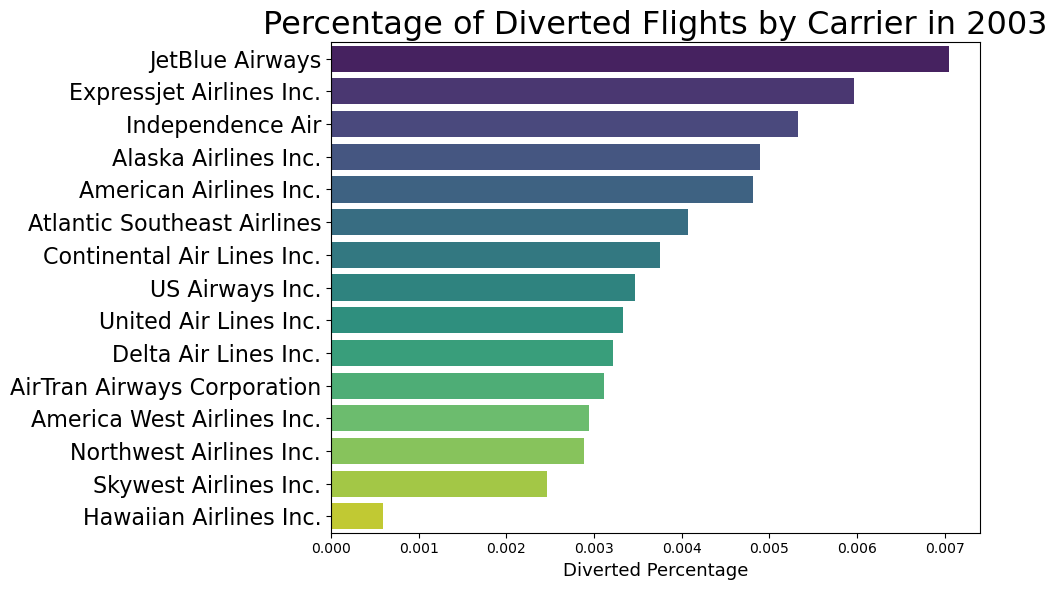

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3471476995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')


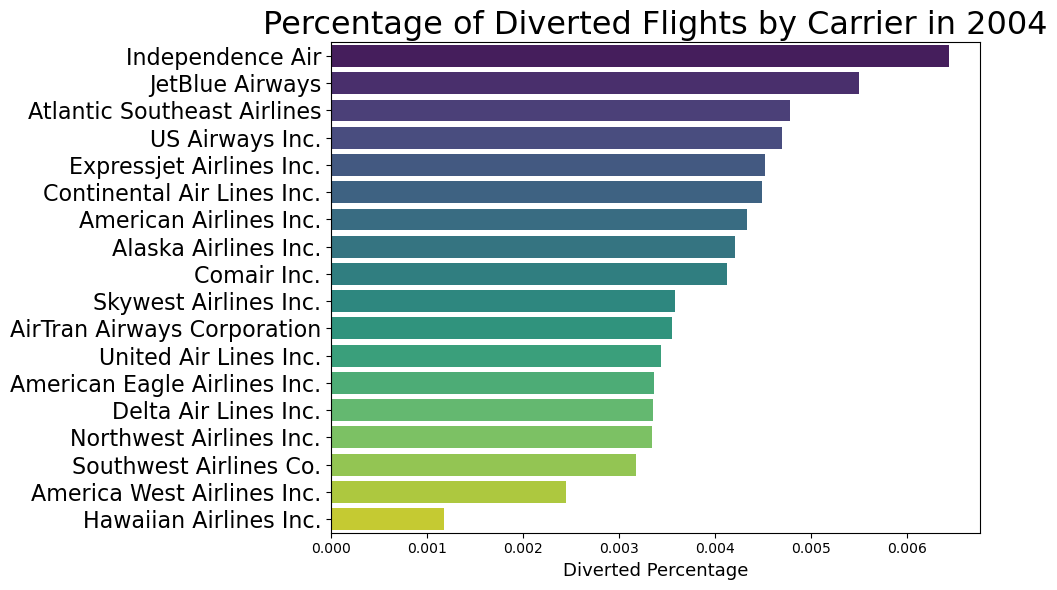

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3471476995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')


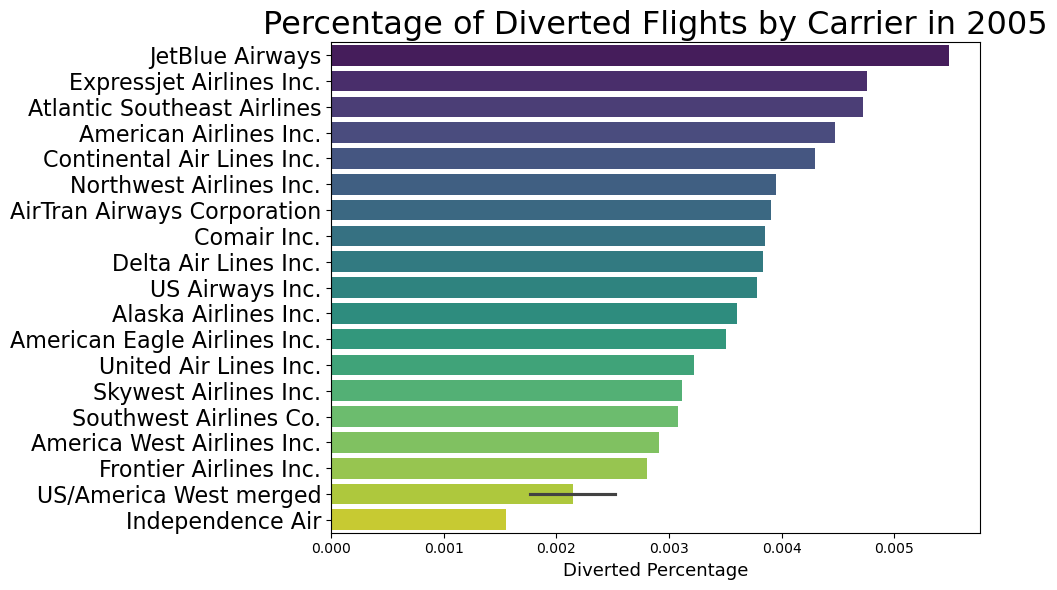

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3471476995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')


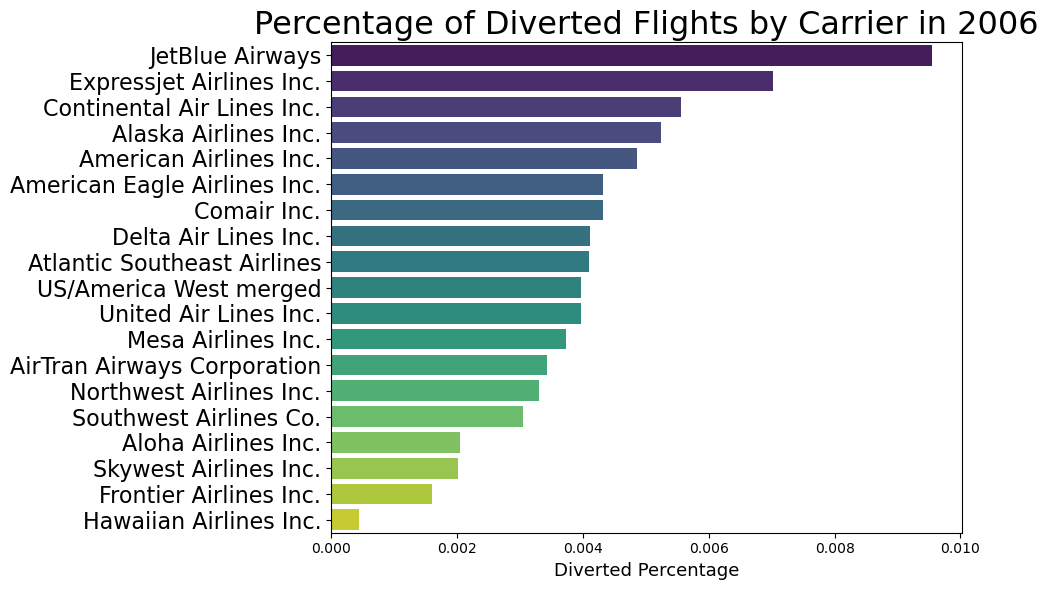

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3471476995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')


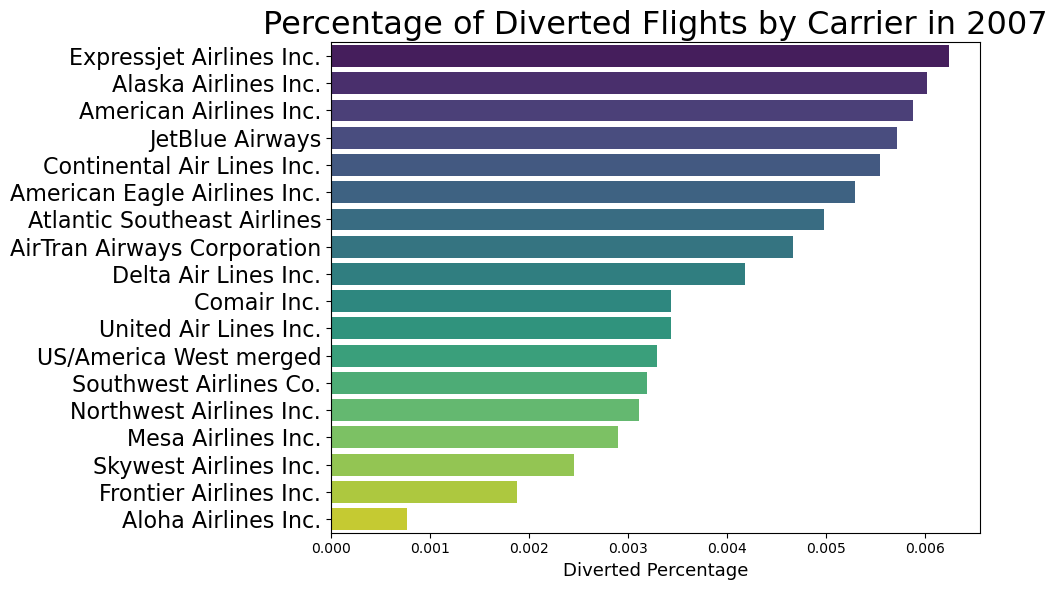

In [56]:
for year in range(2003, 2008):
    # Filter for the current year and sort by DivertedPct for proper ordering on y-axis
    df_year = carrier_delay[carrier_delay['Year'].astype(int) == year].copy()
    df_year = df_year[df_year['DivertedPct'] > 0]
    df_year.sort_values('DivertedPct', inplace=True, ascending = False)
    
    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='DivertedPct', y='CarrierName', data=df_year, palette='viridis')
    
    # Add titles and labels
    plt.title(f"Percentage of Diverted Flights by Carrier in {year}", fontsize = 23)
    plt.xlabel("Diverted Percentage", fontsize = 13)
    plt.ylabel("")
    plt.yticks(fontsize=16) 
    plt.tight_layout()
    plt.show()

It is shown that most carriers have diversion rate below 0.4%, while JetBlue Airways (B6) and Expressjet Airlines (XE) have well above 0.5% diversion rate in 2006-2007. These two carriers were also quite often on the top of the list in terms of diverted flight percentage from 2003-2007.

### Distance impact on divertion

In [57]:
# Display average distance by year and diversion status
distance_by_year_diverted = flight_plane_airport.groupby(['Year', 'Diverted']).agg({'Distance': 'mean'}).reset_index()
print(distance_by_year_diverted.sort_values(by='Year', ascending=False))

   Year  Diverted    Distance
8  2007     False  713.411175
9  2007      True  923.873818
6  2006     False  714.296726
7  2006      True  970.764347
4  2005     False  721.610094
5  2005      True  903.147149
2  2004     False  716.104091
3  2004      True  888.752982
0  2003     False  746.010178
1  2003      True  926.956974


For all the years, distance for diverted flights were consistently higher on average than flights that were not diverted.

### Month and Day of Week impact on divertion

In [58]:
diverted_summary = (
    flight_plane_airport.groupby(['Year', 'Month', 'DayOfWeek'])
    .agg(Flights=('Diverted', 'count'),
         Diverted=('Diverted', 'sum'))
    .reset_index()
)

# Calculate DivertedPct
diverted_summary['DivertedPct'] = diverted_summary['Diverted'] / diverted_summary['Flights']

# Print the summary
print(diverted_summary)

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\871398148.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flight_plane_airport.groupby(['Year', 'Month', 'DayOfWeek'])


     Year Month DayOfWeek  Flights  Diverted  DivertedPct
0    2003    01         1    11060        47     0.004250
1    2003    01         2     9246        30     0.003245
2    2003    01         3    12925        39     0.003017
3    2003    01         4    15105        40     0.002648
4    2003    01         5    15609        50     0.003203
..    ...   ...       ...      ...       ...          ...
415  2007    12         3    33087        81     0.002448
416  2007    12         4    35110       128     0.003646
417  2007    12         5    40435       165     0.004081
418  2007    12         6    34769       184     0.005292
419  2007    12         7    42671       189     0.004429

[420 rows x 6 columns]


c:\Users\steve\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1200x600 with 0 Axes>

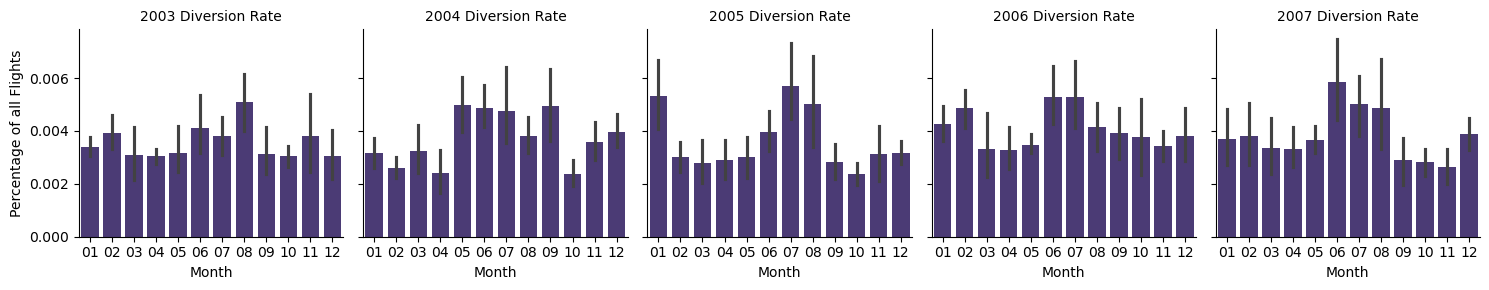

In [59]:
# Set figure size
plt.figure(figsize=(12, 6))

g = sns.FacetGrid(diverted_summary, col="Year", palette='viridies')
g.map(sns.barplot, "Month", "DivertedPct")

# Add titles and labels
g.set_titles(col_template="{col_name} Diversion Rate")
g.set_ylabels("Percentage of all Flights")


For 2003-2007, Jun-Aug and Dec-Jan have consistently resulted in more flights as well as higher percentage of diverted flights, I will create a dummy variable `HotMonth` to indicate flights taken in [Jun, Jul, Aug], and `ColdMonth` to indicate flights taken in [Dec, Jan] whether the flight is taken in these months.

In [60]:
flight_plane_airport["HotMonth"] = flight_plane_airport["Month"].isin(['06',
                                                                       '07',
                                                                       '08'])
flight_plane_airport["ColdMonth"] = flight_plane_airport["Month"].isin(['12',
                                                                        '1'])

flight_plane_airport['HotMonth'].value_counts()

HotMonth
False    6123891
True     2497400
Name: count, dtype: int64

In [61]:
flight_plane_airport[flight_plane_airport['Diverted'] == 1].describe()

CRSDepTime  ArrTime   CRSArrTime    FlightNum  ActualElapsedTime  \
count      33591.0      0.0      33591.0      33591.0                0.0   
mean   1392.030097     <NA>  1592.677771  2153.600845               <NA>   
min            8.0     <NA>          0.0          1.0               <NA>   
25%         1055.0     <NA>       1318.0        547.0               <NA>   
50%         1420.0     <NA>       1644.0       1527.0               <NA>   
75%         1730.0     <NA>       1939.0       3687.5               <NA>   
max         2359.0     <NA>       2359.0       9601.0               <NA>   
std     434.749675     <NA>   462.904402  1917.035993               <NA>   

       CRSElapsedTime  AirTime  ArrDelay   DepDelay    Distance  ...  \
count         33589.0      0.0   33591.0    33591.0     33591.0  ...   
mean       153.000804     <NA>       0.0  38.597958  925.647733  ...   
min             -97.0     <NA>       0.0        0.0         6.0  ...   
25%              95.0     <NA>       0.0        1.0       461.0  ...   
50%             135.0     <NA>       0.0       13.0       760.0  ...   
75%             185.0     <NA>       0.0       48.0      1162.0  ...   
max            1031.0     <NA>       0.0     1345.0      4962.0  ...   
std         83.781103     <NA>       0.0  65.813478  653.078375  ...   

       SecurityDelay  LateAircraftDelay  TotalDelay          year  PlaneAge  \
count        33591.0            33591.0     33591.0  33591.000000   33591.0   
mean             0.0                0.0   38.597958   1996.384270  9.050966   
min              0.0                0.0         0.0   1956.000000       0.0   
25%              0.0                0.0         1.0   1992.000000       4.0   
50%              0.0                0.0        13.0   1999.000000       7.0   
75%              0.0                0.0        48.0   2002.000000      14.0   
max              0.0                0.0      1345.0   2007.000000      51.0   
std              0.0                0.0   65.813478      7.287495  7.281489   

                lat          long      lat_dest     long_dest  \
count  33591.000000  33591.000000  33591.000000  33591.000000   
mean      37.081861    -93.263777     37.263110    -92.868207   
min       17.701889   -176.646031     18.008303   -165.445246   
25%       33.562943   -104.667002     32.895951    -97.654394   
50%       37.505167    -87.904464     38.373151    -87.904464   
75%       40.788388    -81.202139     40.777243    -80.290556   
max       71.285448    -64.798556     71.285448    -64.973361   
std        5.888556     16.904987      5.949411     16.823946   

                          DepTime.dt  
count                          33591  
mean   2005-12-11 10:13:15.432705152  
min              2003-01-01 17:18:00  
25%              2004-11-23 12:21:00  
50%              2006-02-18 08:36:00  
75%              2007-02-25 09:49:00  
max              2007-12-31 22:47:00  
std                              NaN  

[8 rows x 25 columns]

There are some features with absolutely no data for diverted flights, including: `ArrTime`, `ActualElapsedTime` and `AirTime`. These features will therefore not be included in the logistic regression model.

`TaxiIn` and `CRSElapsedTime` also contains some missing data, these observations will be imputed by their mean values.

I will also exclude some other irrelevant features including: `Cancelled`, `CancellationCode`, `Dest`, `Origin`, `TailNum` and `FlightNum`

In [62]:
# Drop irrelevant features
flight_plane_airport = flight_plane_airport.drop(columns=['AirTime', 'ActualElapsedTime', 'ArrTime', 'Cancelled', 'CancellationCode', 'Dest', 'Origin', 'TailNum', 'FlightNum'])

# Impute missing values in TaxiIn and CRSElapsedTime with their means
flight_plane_airport['TaxiIn'] = flight_plane_airport['TaxiIn'].fillna(int(flight_plane_airport['TaxiIn'].mean()))
flight_plane_airport['CRSElapsedTime'] = flight_plane_airport['CRSElapsedTime'].fillna(int(flight_plane_airport['CRSElapsedTime'].mean()))

In [63]:
print(flight_plane_airport.shape)

(8621291, 39)


In [64]:
flight_plane_airport.describe()

CRSDepTime   CRSArrTime  CRSElapsedTime   ArrDelay   DepDelay  \
count    8621291.0    8621291.0       8621291.0  8621291.0  8621291.0   
mean   1434.047908  1592.929828      126.234576   33.52924  30.505304   
min            1.0          0.0           -97.0        0.0        0.0   
25%         1100.0       1240.0            77.0        6.0        4.0   
50%         1450.0       1640.0           109.0       17.0       15.0   
75%         1805.0       1955.0           155.0       41.0       38.0   
max         2359.0       2400.0          1375.0     2598.0     2601.0   
std     443.261092   469.455958       68.775745  47.645584  46.278539   

         Distance     TaxiIn    TaxiOut  CarrierDelay  WeatherDelay  ...  \
count   8621291.0  8621291.0  8621291.0     8621291.0     8621291.0  ...   
mean   720.277037   8.908427  19.134071      8.726098      1.887324  ...   
min           6.0        0.0        0.0           0.0           0.0  ...   
25%         326.0        4.0       11.0           0.0           0.0  ...   
50%         576.0        5.0       15.0           0.0           0.0  ...   
75%         936.0        8.0       22.0           1.0           0.0  ...   
max        4962.0     1523.0     1439.0        2580.0        1510.0  ...   
std    555.987162  55.252354  15.754392     29.454684     14.344016  ...   

       SecurityDelay  LateAircraftDelay  TotalDelay          year   PlaneAge  \
count      8621291.0          8621291.0   8621291.0  8.621291e+06  8621291.0   
mean        0.067591          10.827822   93.879321  1.996276e+03   9.105245   
min              0.0                0.0         0.0  1.956000e+03        0.0   
25%              0.0                0.0        12.0  1.992000e+03        4.0   
50%              0.0                0.0        46.0  1.998000e+03        7.0   
75%              0.0                0.0       118.0  2.002000e+03       14.0   
max            533.0             1407.0      7797.0  2.007000e+03       51.0   
std         1.940525          29.426208  139.778047  7.135973e+00   7.125383   

                lat          long      lat_dest     long_dest  \
count  8.621291e+06  8.621291e+06  8.621291e+06  8.621291e+06   
mean   3.710911e+01 -9.461235e+01  3.715142e+01 -9.477013e+01   
min    1.770189e+01 -1.766460e+02  1.770189e+01 -1.766460e+02   
25%    3.364044e+01 -1.119778e+02  3.364044e+01 -1.119778e+02   
50%    3.761900e+01 -8.790446e+01  3.761900e+01 -8.790446e+01   
75%    4.078839e+01 -8.184940e+01  4.078839e+01 -8.131603e+01   
max    7.128545e+01 -6.479856e+01  7.128545e+01 -6.479856e+01   
std    5.384523e+00  1.701850e+01  5.538662e+00  1.756528e+01   

                          DepTime.dt  
count                        8621291  
mean   2005-11-22 19:18:29.947130368  
min              2003-01-01 00:03:00  
25%              2004-10-21 18:14:00  
50%              2006-01-13 08:00:00  
75%              2007-02-13 10:33:00  
max              2007-12-31 23:59:00  
std                              NaN  

[8 rows x 21 columns]

There are some observations with negative `CRSElapsedTime`, I will assume those were corrupt data and exclude them.

In [65]:
# Remove rows with negative CRSElapsedTime
flight_plane_airport = flight_plane_airport[flight_plane_airport['CRSElapsedTime'] >= 0]

### Engine type impact on diversion

In [66]:
# Group by Year and engine_type, then calculate the summarized values
engine_summary = flight_plane_airport.groupby(["Year", "engine_type"]).agg(
    Diverted=("Diverted", "sum"),
    Flights=("Diverted", "count")
).reset_index()

# Calculate DivertedPctWithin each type
engine_summary["DivertedPctWithin"] = engine_summary["Diverted"] / engine_summary["Flights"]

# Group by Year again and calculate DivertedPctOverall
engine_summary["DivertedPctOverall"] = engine_summary.groupby("Year")["Diverted"].transform(lambda x: x / x.sum())

print(engine_summary)


C:\Users\steve\AppData\Local\Temp\ipykernel_22412\1134508345.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engine_summary = flight_plane_airport.groupby(["Year", "engine_type"]).agg(


    Year    engine_type  Diverted  Flights  DivertedPctWithin  \
0   2003        4 Cycle         5      874           0.005721   
1   2003  Reciprocating        28     5362           0.005222   
2   2003      Turbo-Fan      1961   510616           0.003840   
3   2003      Turbo-Jet      1368   383169           0.003570   
4   2003     Turbo-Prop       192    83800           0.002291   
5   2003    Turbo-Shaft         1      487           0.002053   
6   2004        4 Cycle         3     1017           0.002950   
7   2004  Reciprocating        34     7293           0.004662   
8   2004      Turbo-Fan      3496   910766           0.003839   
9   2004      Turbo-Jet      1930   530468           0.003638   
10  2004     Turbo-Prop       225    65732           0.003423   
11  2004    Turbo-Shaft         4      560           0.007143   
12  2005        4 Cycle         4     1232           0.003247   
13  2005  Reciprocating        41     7419           0.005526   
14  2005      Turbo-Fan  

Summary Plots

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3240181497.py:6: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.barplot(


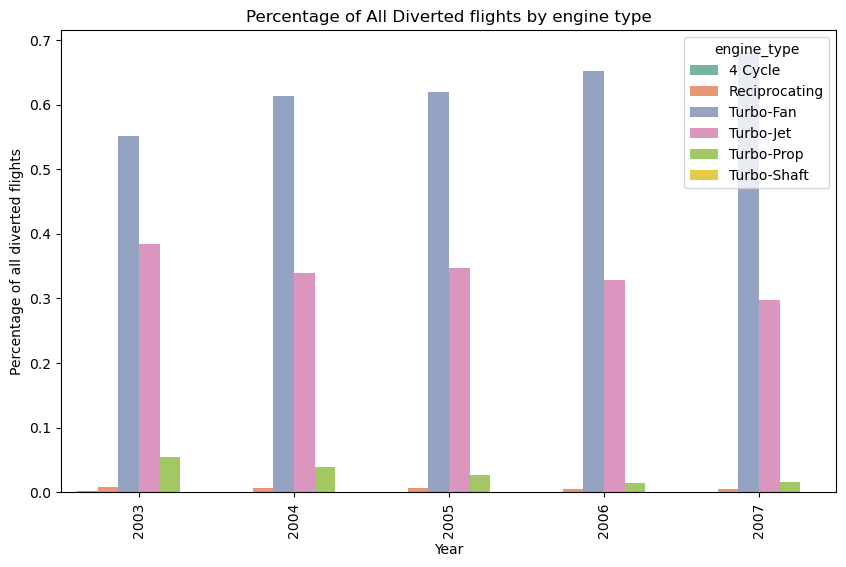

In [67]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=engine_summary, 
    x="Year", 
    y="DivertedPctOverall", 
    hue="engine_type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of All Diverted flights by engine type")
plt.xlabel("Year")
plt.ylabel("Percentage of all diverted flights")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\1233357315.py:6: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.barplot(


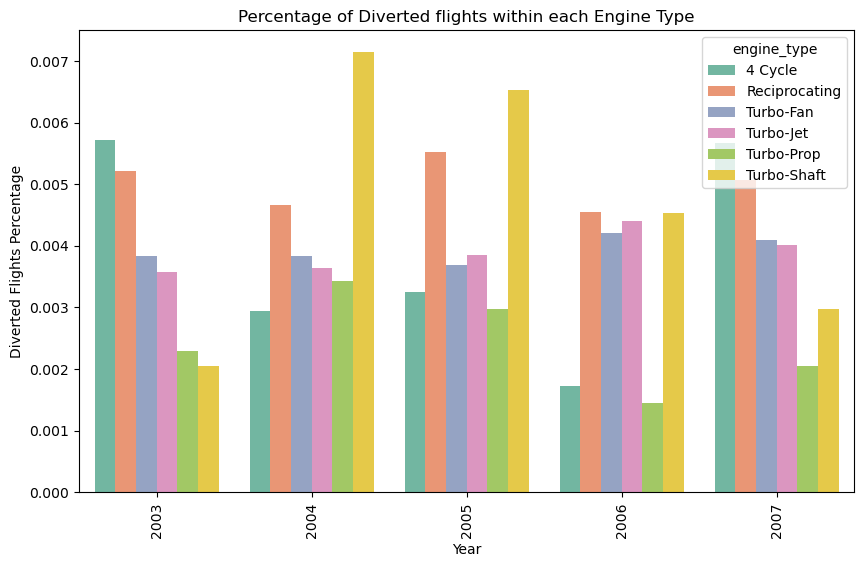

In [68]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=engine_summary, 
    x="Year", 
    y="DivertedPctWithin", 
    hue="engine_type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of Diverted flights within each Engine Type")
plt.xlabel("Year")
plt.ylabel("Diverted Flights Percentage")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Of all diverted flights, planes with Turbo-Fan accounts to more than 50% of them, while Turbo-Jet accounts for more than 30% of diverted flights each year. However, turbo fan and jet type aircraft engine have very consistant diversion rate across all years, where as all other aircraft engines have higher fluctuations, I will create an indicator variable to indicate whether the plane engine has turbo-jet or turbo-fan ('TurboEngine')

In [69]:
flight_plane_airport['TurboEngine'] = flight_plane_airport['engine_type'].isin(['Turbo-Jet','Turbo-Fan'])

### Aircraft type impact on diversion

In [70]:
# Group by Year and engine_type, then calculate the summarized values
aircraft_summary = flight_plane_airport.groupby(["Year", "aircraft_type"]).agg(
    Diverted=("Diverted", "sum"),
    Flights=("Diverted", "count")
).reset_index()

# Calculate DivertedPctWithin each type
aircraft_summary["DivertedPctWithin"] = aircraft_summary["Diverted"] / aircraft_summary["Flights"]

# Group by Year again and calculate DivertedPctOverall
aircraft_summary["DivertedPctOverall"] = aircraft_summary.groupby("Year")["Diverted"].transform(lambda x: x / x.sum())

print(aircraft_summary)

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\733159744.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aircraft_summary = flight_plane_airport.groupby(["Year", "aircraft_type"]).agg(


    Year             aircraft_type  Diverted  Flights  DivertedPctWithin  \
0   2003                   Balloon         0        0                NaN   
1   2003   Fixed Wing Multi-Engine      3526   978627           0.003603   
2   2003  Fixed Wing Single-Engine        28     5194           0.005391   
3   2003                Rotorcraft         1      487           0.002053   
4   2004                   Balloon         0        0                NaN   
5   2004   Fixed Wing Multi-Engine      5657  1508265           0.003751   
6   2004  Fixed Wing Single-Engine        31     7011           0.004422   
7   2004                Rotorcraft         4      560           0.007143   
8   2005                   Balloon         0        0                NaN   
9   2005   Fixed Wing Multi-Engine      6475  1741015           0.003719   
10  2005  Fixed Wing Single-Engine        37     7483           0.004945   
11  2005                Rotorcraft         4      612           0.006536   
12  2006    

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2874971387.py:6: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.barplot(


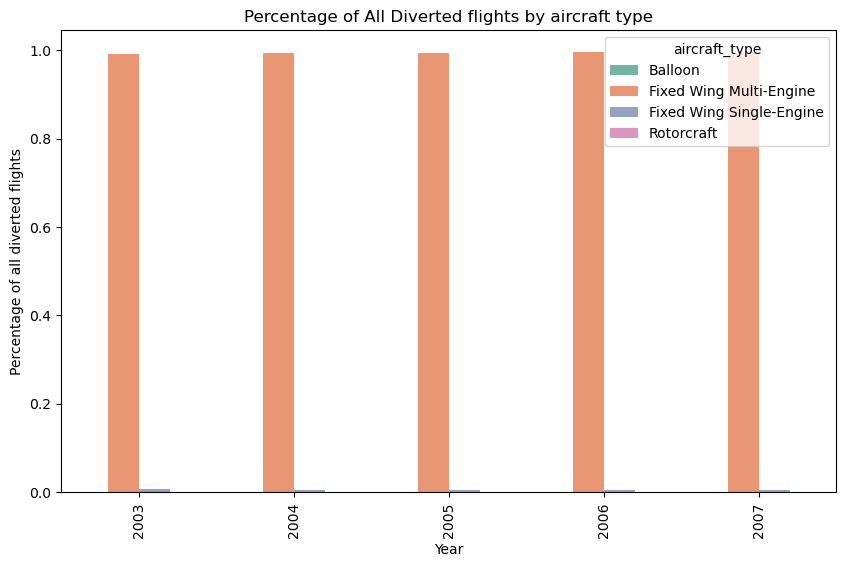

In [71]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aircraft_summary, 
    x="Year", 
    y="DivertedPctOverall", 
    hue="aircraft_type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of All Diverted flights by aircraft type")
plt.xlabel("Year")
plt.ylabel("Percentage of all diverted flights")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\3716721584.py:6: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.barplot(


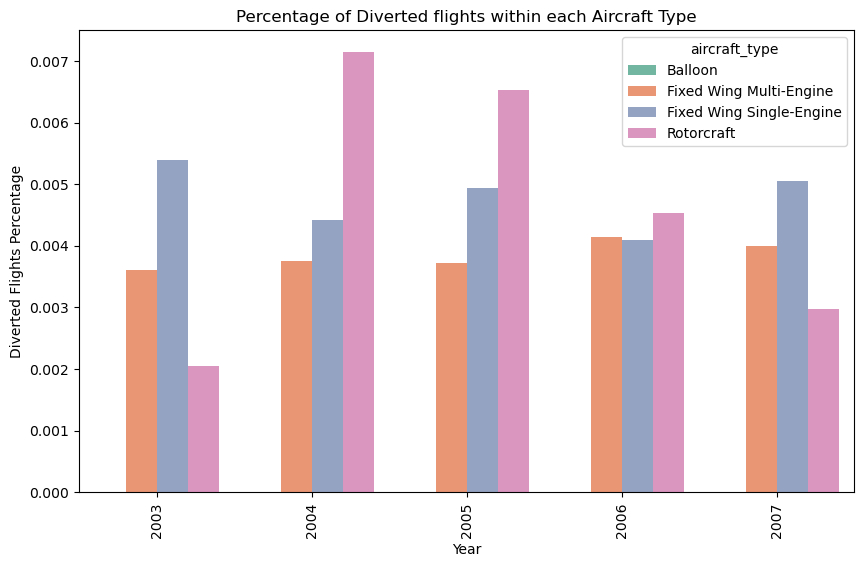

In [72]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aircraft_summary, 
    x="Year", 
    y="DivertedPctWithin", 
    hue="aircraft_type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of Diverted flights within each Aircraft Type")
plt.xlabel("Year")
plt.ylabel("Diverted Flights Percentage")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Basically all diverted flights have 'Fixed Wing Multi-Engine' type because other type of aircraft have a lot less flights. However, of all aircraft types, Rotorcraft and Fixed Wing Single-Engine aircrafts are inconsistently more prone to flight diversion. A new indicator variable 'NotMultiEngine' was created to indicate planes that are not multi engine type for the flight

In [73]:
# Create the 'MultiEngine' indicator, 1 if 'aircraft_type' is 'Fixed Wing Multi-Engine', otherwise 0
flight_plane_airport['MultiEngine'] = (flight_plane_airport['aircraft_type'] == 'Fixed Wing Multi-Engine').astype(int)

print(flight_plane_airport['MultiEngine'].value_counts())


MultiEngine
1    8581243
0      40011
Name: count, dtype: int64


### Flight type impact on diversion

In [74]:
# Group by Year and type, then calculate the summarized values
type_summary = flight_plane_airport.groupby(["Year", "type"]).agg(
    Diverted=("Diverted", "sum"),
    Flights=("Diverted", "count")
).reset_index()

# Calculate DivertedPctWithin each type
type_summary["DivertedPctWithin"] = type_summary["Diverted"] / type_summary["Flights"]

# Group by Year again and calculate DivertedPctOverall
type_summary["DivertedPctOverall"] = type_summary.groupby("Year")["Diverted"].transform(lambda x: x / x.sum())

print(type_summary)

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\363397631.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_summary = flight_plane_airport.groupby(["Year", "type"]).agg(


    Year                 type  Diverted  Flights  DivertedPctWithin  \
0   2003             Co-Owner         6      927           0.006472   
1   2003          Corporation      3520   976892           0.003603   
2   2003  Foreign Corporation        14     2424           0.005776   
3   2003           Individual        13     3756           0.003461   
4   2003          Partnership         2      309           0.006472   
5   2004             Co-Owner         9     1156           0.007785   
6   2004          Corporation      5617  1502221           0.003739   
7   2004  Foreign Corporation        40     6901           0.005796   
8   2004           Individual        24     5164           0.004648   
9   2004          Partnership         2      394           0.005076   
10  2005             Co-Owner         8     1195           0.006695   
11  2005          Corporation      6431  1735459           0.003706   
12  2005  Foreign Corporation        41     6617           0.006196   
13  20

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2925067583.py:6: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  ax = sns.barplot(


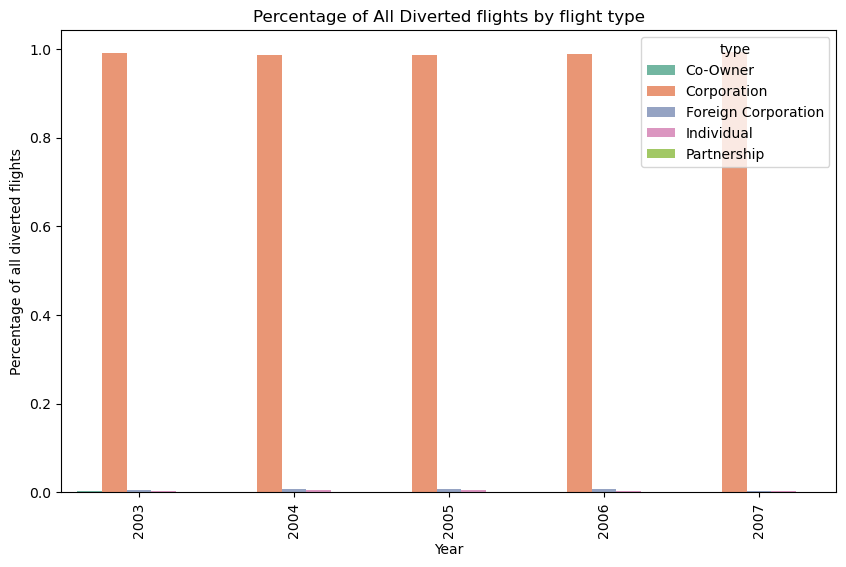

In [75]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=type_summary, 
    x="Year", 
    y="DivertedPctOverall", 
    hue="type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of All Diverted flights by flight type")
plt.xlabel("Year")
plt.ylabel("Percentage of all diverted flights")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\2740765328.py:6: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  ax = sns.barplot(


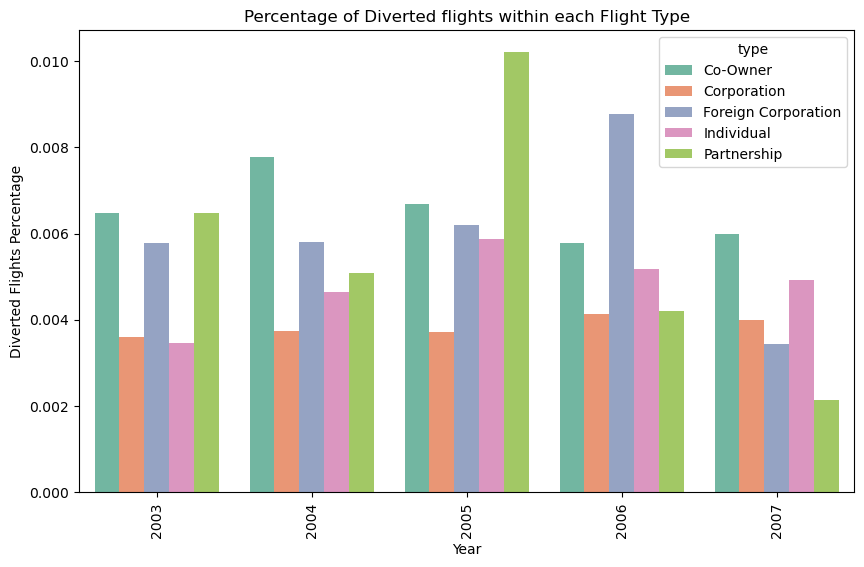

In [76]:
# Set color palette
palette = sns.color_palette("Set2")

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=type_summary, 
    x="Year", 
    y="DivertedPctWithin", 
    hue="type",
    palette=palette
)

# Set labels and title
plt.title("Percentage of Diverted flights within each Flight Type")
plt.xlabel("Year")
plt.ylabel("Diverted Flights Percentage")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Similarly, almost all diverted planes are corporation type, other flight type has very little flights. However, of all type of flights, corporation flights are least prone to flight diversions. An indicator variable 'NotCorpo' was created to indicate flights that are not corporation type.

In [77]:
# Create the 'Corpo' indicator, 1 if 'type' is 'Corporation', otherwise 0
flight_plane_airport['Corpo'] = (flight_plane_airport['type'] == 'Corporation').astype(int)

print(flight_plane_airport['Corpo'].value_counts())

Corpo
1    8556967
0      64287
Name: count, dtype: int64


To visualize the pairwise correlation between `Diverted` and other numeric variables, I will create a correlation plot of features for all years as follows: 

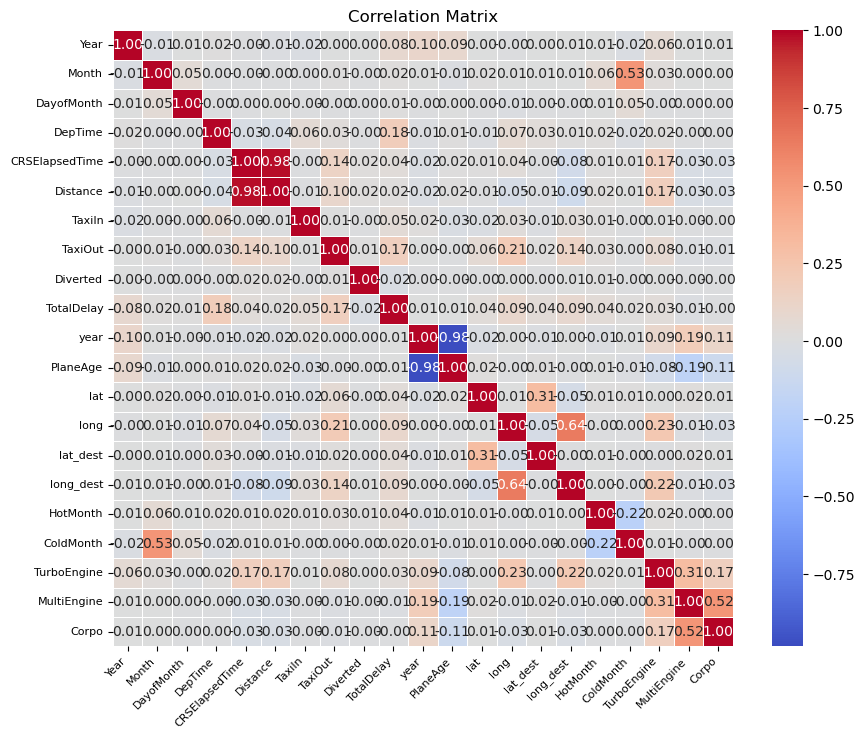

In [78]:
# Subset numeric features by dropping non-numeric columns
numeric_features = flight_plane_airport[['Year',
                                         'Month',
                                         'DayofMonth',
                                         'DepTime',
                                         'CRSElapsedTime',
                                         'Distance',
                                         'TaxiIn',
                                         'TaxiOut',
                                         'Diverted',
                                         'TotalDelay',
                                         'year',
                                         'PlaneAge',
                                         'lat',
                                         'long',
                                         'lat_dest',
                                         'long_dest',
                                         'HotMonth',
                                         'ColdMonth',
                                         'TurboEngine',
                                         'MultiEngine',
                                         'Corpo']]

# Calculate correlation matrix
corr_matrix = numeric_features.corr()

# Plot correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)

# Customize the labels
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.title("Correlation Matrix")

# Show the plot
plt.show()

Based on the correlation matrix of all numerical features, no features exhibit a clear correlation with the target variable `Diverted`.

In [79]:
# Select a subset of features for logistic regression
flight_plane_airport_subset = flight_plane_airport[['Year',
                                                    'CRSElapsedTime',
                                                    'Distance',
                                                    'Diverted',
                                                    'PlaneAgeCategory',
                                                    'lat',
                                                    'long',
                                                    'lat_dest',
                                                    'long_dest',
                                                    'CarrierName',
                                                    'HotMonth',
                                                    'ColdMonth',
                                                    'TurboEngine',
                                                    'MultiEngine',
                                                    'Corpo']]
flight_plane_airport_subset.keys()

Index(['Year', 'CRSElapsedTime', 'Distance', 'Diverted', 'PlaneAgeCategory',
       'lat', 'long', 'lat_dest', 'long_dest', 'CarrierName', 'HotMonth',
       'ColdMonth', 'TurboEngine', 'MultiEngine', 'Corpo'],
      dtype='object')

### Logistic Regression

To fit the logistic regression model, the data was split into training (80%) and testing (20%) sets for each year separately. Remaining missing values within continuous variables were imputed with their mean, and missing values within categorical variables are imputed with their mode. And then Factor variables (e.g. ‘UniqueCarrier’, ‘type’) were converted into dummy variables. The threshold for the positive class was adjusted to 0.004 based on the proportion of diverted flights. The model coefficients were plotted for each year to visualize the impact of different features on the probability of diversion. 

In [80]:
# compute class proportions of 'Diverted'
proportions = flight_plane_airport_subset['Diverted'].value_counts(normalize=True)
print(proportions)

Diverted
False    0.996107
True     0.003893
Name: proportion, dtype: float64


The threshold for predicting positive class is set to 0.004 (based on the proportion of positive class).

I created three specialized functions: 

First function for training the model,  second for plotting the coefficients of the model, and last one for evaluating the model prediction.

In [81]:
def train_logreg(X_train, y_train):
    """
    Train a logistic regression model with preprocessing.
    Returns trained model and coefficients.
    """
    # identify numerical and categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category','bool']).columns.tolist()
    
    # Define preprocessing transformers
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
        #('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])
    
    # apply transformers into preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Define the complete pipeline: preprocessing + logistic regression model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression(solver='liblinear', max_iter=500))
    ])

    
    # Train the model
    model.fit(X_train, y_train)

    # put features and coefficients in a df
    coef = pd.DataFrame({
        'Variable': model.named_steps['preprocessor'].get_feature_names_out(),
        'Coefficient': model.named_steps['logreg'].coef_.flatten()
    })
    # Rename columns that start with 'cat_' or 'num_' or 'CarrierName_' to empty to make names shorter
    coef['Variable'] = coef['Variable'].str.replace(r'^cat_', '', regex=True)
    coef['Variable'] = coef['Variable'].str.replace(r'^num_', '', regex=True)
    coef['Variable'] = coef['Variable'].str.replace(r'_CarrierName_', '', regex=True)
    return model, coef

def plot_coef(coef_df, year):
    """
    Plot the coefficients of the fitted logistic regression model,
    using the DataFrame with feature names and coefficients.
    """
    # Sort the DataFrame by the coefficient values
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    # Plot the coefficients using a horizontal bar plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Variable', data=coef_df) #, palette='viridis'
    # Left-align y-tick labels (feature names)
    # ax.set_yticklabels(ax.get_yticklabels(), ha='left')
    # title and labs
    plt.tight_layout()
    plt.title(f'Model Coefficients for Year {year}',fontsize=25)
    plt.xlabel('Coefficient Value',fontsize=20)
    plt.ylabel('')
    plt.yticks(fontsize=17)
    plt.show()


def eval_model(y_test, y_pred_proba, threshold, year):
    """
    Evaluate model performance.
    """
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"\n{year} Model Performance")
    print(f"Precision: {report['1']['precision']:.2f}")
    print(f"Recall: {report['1']['recall']:.2f}")
    print(f"Sensitivity: {report['1']['recall']:.2f}")
    print(f"Specificity: {report['0']['recall']:.2f}")

C:\Users\steve\AppData\Local\Temp\ipykernel_22412\595209063.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Diverted'] = df['Diverted'].astype(int)  # Convert target variable


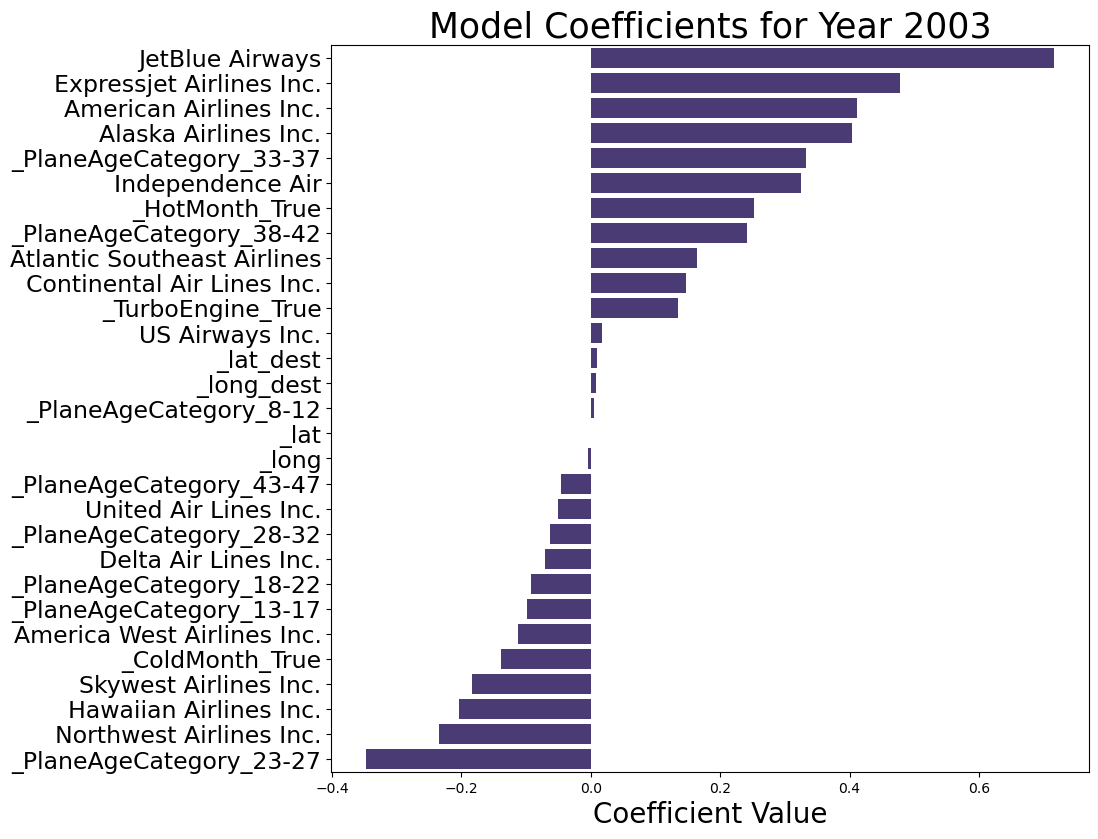


2003 Model Performance
Precision: 0.01
Recall: 0.45
Sensitivity: 0.45
Specificity: 0.70


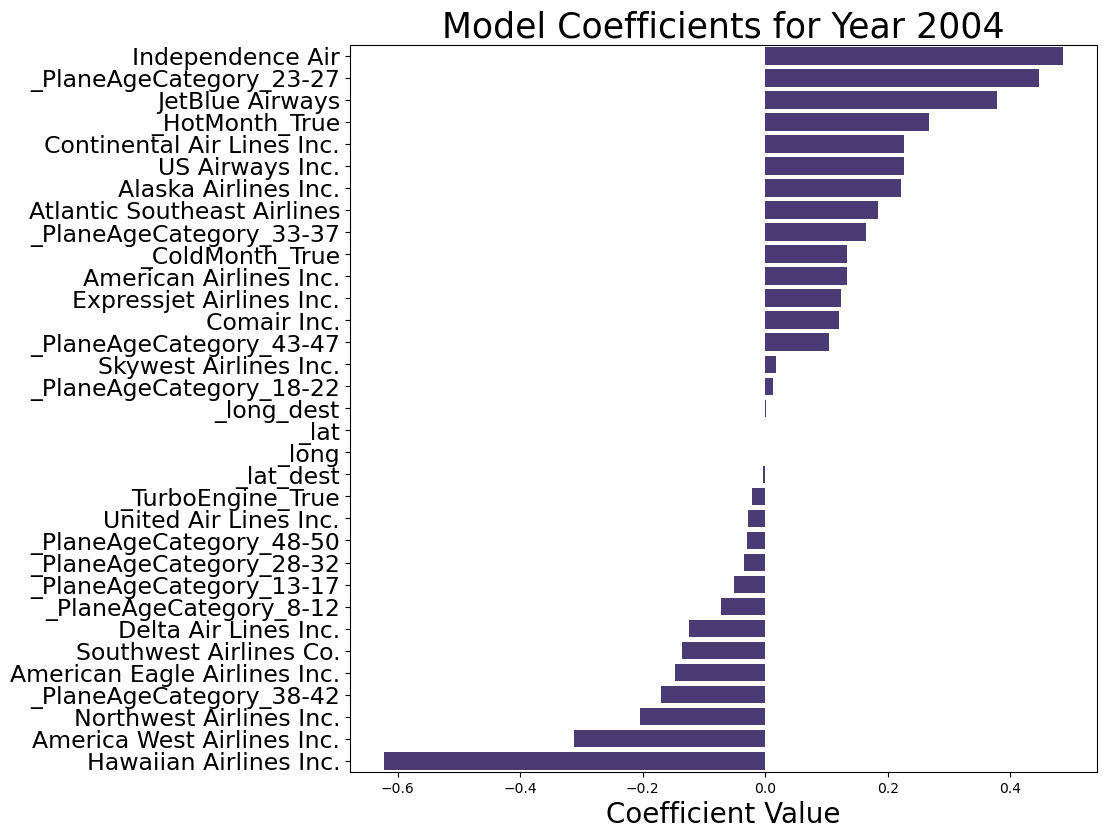


2004 Model Performance
Precision: 0.00
Recall: 0.44
Sensitivity: 0.44
Specificity: 0.65


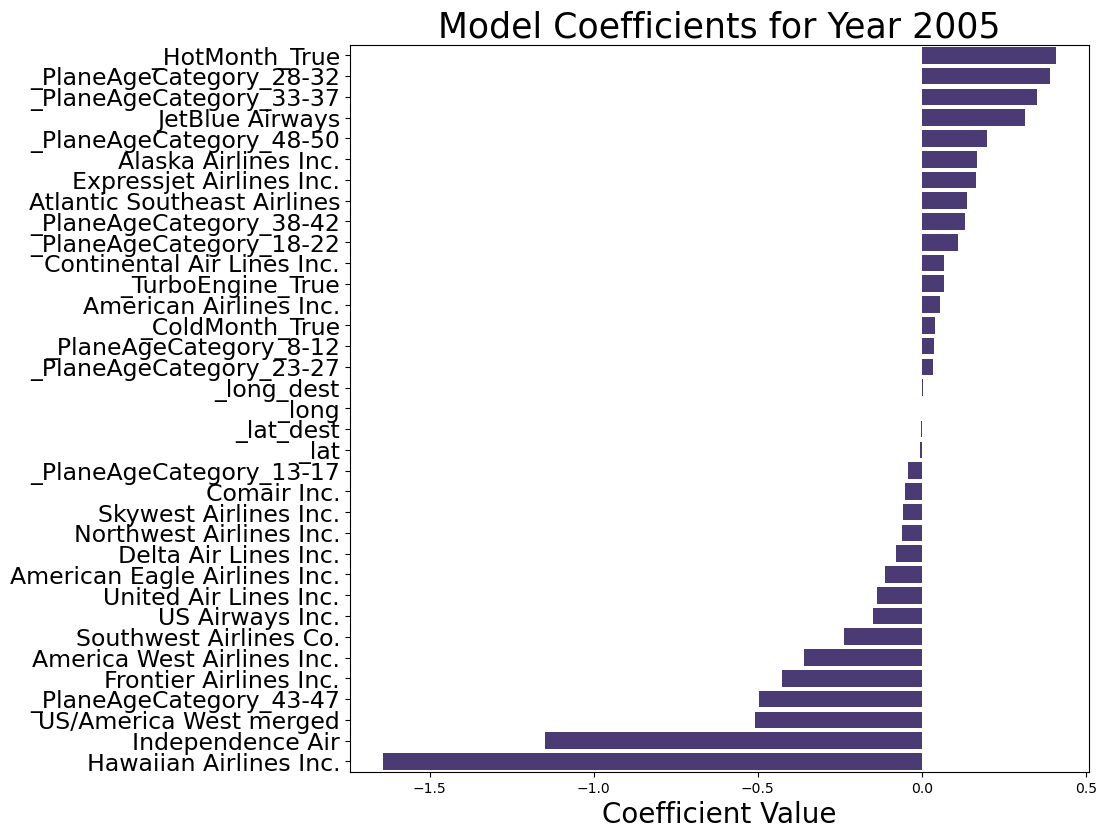


2005 Model Performance
Precision: 0.01
Recall: 0.48
Sensitivity: 0.48
Specificity: 0.64


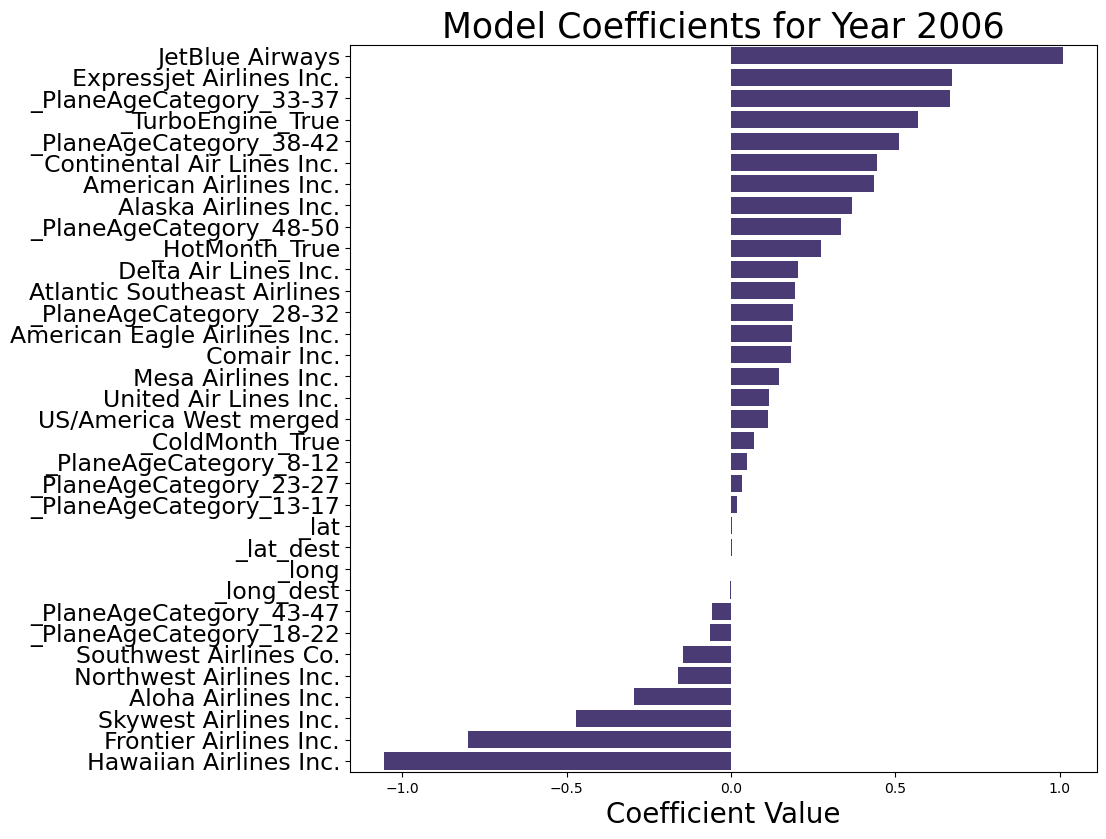


2006 Model Performance
Precision: 0.01
Recall: 0.57
Sensitivity: 0.57
Specificity: 0.56


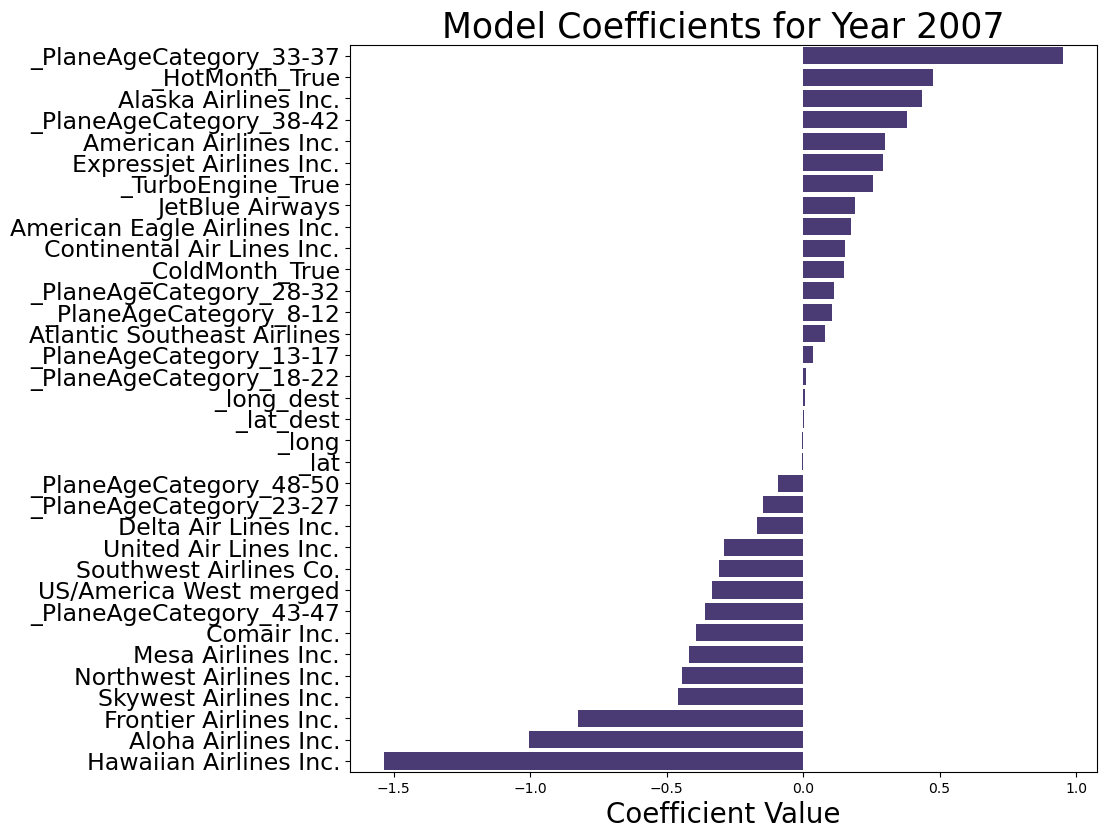


2007 Model Performance
Precision: 0.01
Recall: 0.62
Sensitivity: 0.62
Specificity: 0.55


In [82]:
def process_yearly_data(df):
    """
    Train and evaluate models year by year.
    """
    df['Diverted'] = df['Diverted'].astype(int)  # Convert target variable
    roc_data_all = pd.DataFrame()
    
    for year in df['Year'].unique():
        year_subset = df[df['Year'] == year].drop(columns=['Year'])
        X = year_subset.drop(columns=['Diverted'])
        y = year_subset['Diverted']
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        
        # Train the model
        model,coef = train_logreg(X_train, y_train)
        
        # Plot coefficients
        plot_coef(coef, year)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_test)
        
        # Evaluate model
        eval_model(y_test, y_pred_proba, threshold=0.004, year=year)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        auc_val = auc(fpr, tpr)
        
        # Store ROC data
        roc_df = pd.DataFrame({'Year': year, 'FPR': fpr, 'TPR': tpr, 'AUC': auc_val})
        roc_data_all = pd.concat([roc_data_all, roc_df], ignore_index=True)
    
    return roc_data_all

roc_data = process_yearly_data(flight_plane_airport_subset)

In [83]:
flight_plane_airport_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8621254 entries, 0 to 8621290
Data columns (total 15 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Year              object  
 1   CRSElapsedTime    Int16   
 2   Distance          Int16   
 3   Diverted          int32   
 4   PlaneAgeCategory  category
 5   lat               float64 
 6   long              float64 
 7   lat_dest          float64 
 8   long_dest         float64 
 9   CarrierName       object  
 10  HotMonth          bool    
 11  ColdMonth         bool    
 12  TurboEngine       bool    
 13  MultiEngine       int32   
 14  Corpo             int32   
dtypes: Int16(2), bool(3), category(1), float64(4), int32(3), object(2)
memory usage: 641.3+ MB


Plot ROC curve

In [84]:
roc_data.head()

Year       FPR       TPR       AUC
0  2003  0.000000  0.000000  0.586461
1  2003  0.000107  0.000000  0.586461
2  2003  0.000117  0.000000  0.586461
3  2003  0.000357  0.002817  0.586461
4  2003  0.000382  0.002817  0.586461

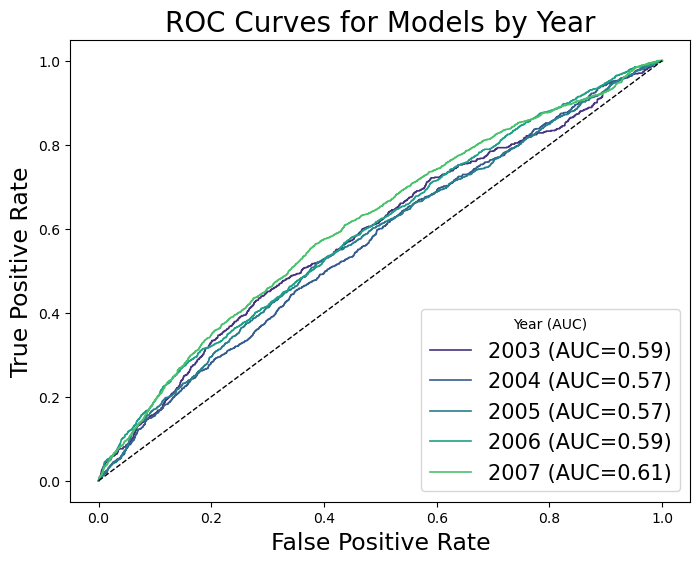

In [85]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot each year's ROC curve
for year in roc_data['Year'].unique():
    year_data = roc_data[roc_data['Year'] == year]
    plt.plot(year_data['FPR'], year_data['TPR'], label=f"{year} (AUC={year_data['AUC'].mean():.2f})", linewidth=1.2)

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Add labels and title
plt.xlabel('False Positive Rate',fontsize=17)
plt.ylabel('True Positive Rate',fontsize=17)
plt.title('ROC Curves for Models by Year', fontsize=20)
plt.legend(title='Year (AUC)', loc='lower right',fontsize=15)

# Show the plot
plt.show()